In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive to access your datasets
drive.mount('/content/drive', force_remount=True)

# Define paths to data folders
MACRO_FOLDER = '/content/drive/MyDrive/processed_data'
FINANCIAL_FOLDER = '/content/drive/MyDrive/financial_info'

Mounted at /content/drive


In [ ]:
def load_and_process_data(country):
    """
    Load and process data for a specific country, standardizing dates and frequencies
    """
    print(f"Processing {country}...")

    try:
        # Define file paths
        macro_path = f"{MACRO_FOLDER}/{country}_macro.csv"
        stock_path = f"{FINANCIAL_FOLDER}/{country}_stock.csv"

        # Load macro data
        macro_df = pd.read_csv(macro_path)
        macro_df['date'] = pd.to_datetime(macro_df['date'])

        # Clean redundant columns in macro data (handling _x and _y duplicates)
        clean_macro = pd.DataFrame()
        clean_macro['date'] = macro_df['date']
        processed_cols = set()

        # Process each column, handling the _x and _y suffix duplicates
        for col in macro_df.columns:
            if col == 'date':
                continue
            # Get base column name (without suffix)
            base_col = col.split('_')[0]
            # Skip if we've already processed this base column
            if base_col in processed_cols:
                continue
            # Choose the best version of the column (prioritize non-suffixed)
            if base_col in macro_df.columns:
                clean_macro[base_col] = pd.to_numeric(macro_df[base_col], errors='coerce')
            elif f"{base_col}_x" in macro_df.columns:
                clean_macro[base_col] = pd.to_numeric(macro_df[f"{base_col}_x"], errors='coerce')
            elif f"{base_col}_y" in macro_df.columns:
                clean_macro[base_col] = pd.to_numeric(macro_df[f"{base_col}_y"], errors='coerce')
            processed_cols.add(base_col)

        # Load stock data, handling the empty first row often present in the files
        with open(stock_path, 'r') as f:
            first_line = f.readline().strip()
        skip_rows = 1 if first_line == '' or ',^' in first_line or ',EZA' in first_line else 0
        stock_df = pd.read_csv(stock_path, skiprows=skip_rows)

        # Handle case sensitivity in column names
        date_col = 'Date' if 'Date' in stock_df.columns else 'date'
        close_col = 'Close' if 'Close' in stock_df.columns else 'close'

        # Create standardized stock dataframe
        stock_clean = pd.DataFrame()
        stock_clean['date'] = pd.to_datetime(stock_df[date_col])
        stock_clean['close'] = pd.to_numeric(stock_df[close_col], errors='coerce')

        # Remove timezone information if present
        if hasattr(stock_clean['date'].dt, 'tz') and stock_clean['date'].dt.tz is not None:
            stock_clean['date'] = stock_clean['date'].dt.tz_localize(None)

        # Set date as index for both dataframes
        clean_macro.set_index('date', inplace=True)
        stock_clean.set_index('date', inplace=True)

        # Resample macro data to monthly frequency with forward fill
        monthly_macro = clean_macro.resample('M').ffill()
        # Ensure stock data is also on monthly frequency
        monthly_stock = stock_clean.resample('M').last()

        # Merge the dataframes on their date indices
        merged_df = pd.merge(
            monthly_stock,
            monthly_macro,
            left_index=True,
            right_index=True,
            how='inner'
        )

        print(f"Successfully processed {country} data: {len(merged_df)} rows, {merged_df.shape[1]} columns")
        print(f"Date range: {merged_df.index.min()} to {merged_df.index.max()}")

        return merged_df

    except Exception as e:
        print(f"Error processing {country}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


In [ ]:
def engineer_features(df):
    """Create features for the market regime classification model"""
    result = df.copy()

    # Price-based features
    result['return_1q'] = result['close'].pct_change(1)
    result['return_2q'] = result['close'].pct_change(2)
    result['volatility_2q'] = result['return_1q'].rolling(2).std()

    # Macro features
    for col in ['GDP', 'CPI', 'UNEMPLOYMENT', 'IMPORTS', 'EXPORTS', 'INTEREST_RATE', 'EXCHANGE_RATE']:
        if col in result.columns:
            result[f'{col}_change'] = result[col].pct_change(1)

    # Interaction features
    if 'INTEREST_RATE' in result.columns and 'CPI' in result.columns:
        result['real_interest_rate'] = result['INTEREST_RATE'] - result['CPI_change']

    if 'EXPORTS' in result.columns and 'IMPORTS' in result.columns:
        result['trade_balance'] = result['EXPORTS'] - result['IMPORTS']
        result['trade_balance_to_gdp'] = result['trade_balance'] / result['GDP'] if 'GDP' in result.columns else np.nan

    # Drop rows with missing values in key features
    result = result.dropna(subset=['return_1q', 'close'])

    return result



In [ ]:
def perform_eda(country_data, country_name):
    """
    Conduct comprehensive exploratory data analysis on the data
    """
    print(f"\n{'='*50}")
    print(f"EXPLORATORY DATA ANALYSIS FOR {country_name.upper()}")
    print(f"{'='*50}")

    if country_data is None or country_data.empty:
        print(f"No data available for {country_name}.")
        return

    # 1. Data Overview and Structure
    print("\n1. Data Structure Check:")
    print(f" - Data shape: {country_data.shape}")
    print(f" - Columns: {country_data.columns.tolist()}")
    print(f" - Date range: {country_data.index.min()} to {country_data.index.max()}")

    # 2. Data Quality Assessment
    print("\n2. Data Quality Assessment:")
    missing = country_data.isnull().sum()
    print(f" - Columns with missing values: {missing[missing > 0].to_dict()}")

    # Create a heatmap to visualize missing values
    plt.figure(figsize=(12, 6))
    sns.heatmap(country_data.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title(f"Missing Values in {country_name} Dataset", fontsize=14)
    plt.tight_layout()
    plt.show()

    # 3. Descriptive Statistics and Distribution Analysis
    print("\n3. Descriptive Statistics:")
    print(country_data.describe())

    # Plot the financial time series
    plt.figure(figsize=(14, 7))
    plt.plot(country_data.index, country_data['close'], 'b-', linewidth=2)
    plt.title(f'{country_name.capitalize()} Market Index Over Time', fontsize=16)
    plt.ylabel('Index Value', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4. Correlation and Redundancy Analysis
    print("\n4. Correlation Analysis:")

    # Calculate correlations between numerical features
    corr_matrix = country_data.select_dtypes(include=[np.number]).corr()

    # Plot correlation heatmap
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f",
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title(f'Correlation Matrix for {country_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Identify highly correlated features
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    if high_corr:
        print("\nHighly correlated feature pairs (|r| > 0.8):")
        for feat1, feat2, corr in high_corr:
            print(f" - {feat1} and {feat2}: {corr:.3f}")

    # 5. Feature Distribution Analysis
    # Select key features for distribution analysis
    key_features = ['close', 'return_1q', 'return_2q', 'volatility_2q']
    key_features.extend([col for col in ['GDP_change', 'CPI_change', 'INTEREST_RATE_change', 'EXCHANGE_RATE_change']
                        if col in country_data.columns])

    print("\n5. Feature Distribution Analysis:")

    # Plot distributions for key features
    plt.figure(figsize=(16, 12))
    for i, feature in enumerate(key_features):
        if feature in country_data.columns:
            plt.subplot(3, 3, i+1)
            sns.histplot(country_data[feature].dropna(), kde=True)
            plt.title(f'Distribution of {feature}')
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 6. Time Series Decomposition
    if 'close' in country_data.columns:
        try:
            from statsmodels.tsa.seasonal import seasonal_decompose

            print("\n6. Time Series Decomposition:")
            # Perform time series decomposition on the close price
            decomposition = seasonal_decompose(country_data['close'], model='additive', period=12)

            # Plot the decomposition
            plt.figure(figsize=(14, 12))
            plt.subplot(411)
            plt.plot(decomposition.observed)
            plt.title('Observed', fontsize=14)
            plt.grid(True, alpha=0.3)

            plt.subplot(412)
            plt.plot(decomposition.trend)
            plt.title('Trend', fontsize=14)
            plt.grid(True, alpha=0.3)

            plt.subplot(413)
            plt.plot(decomposition.seasonal)
            plt.title('Seasonality', fontsize=14)
            plt.grid(True, alpha=0.3)

            plt.subplot(414)
            plt.plot(decomposition.resid)
            plt.title('Residuals', fontsize=14)
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()
        except:
            print("Time series decomposition could not be performed (insufficient data or invalid input).")

    # 7. Return Distribution and Volatility Clustering
    if 'return_1q' in country_data.columns:
        print("\n7. Return Distribution and Volatility Analysis:")

        plt.figure(figsize=(14, 6))

        # Plot return distribution with normal curve for comparison
        plt.subplot(121)
        sns.histplot(country_data['return_1q'].dropna(), kde=True, stat='density')

        # Add a normal distribution curve for comparison
        from scipy.stats import norm
        x = np.linspace(country_data['return_1q'].min(), country_data['return_1q'].max(), 100)
        mean = country_data['return_1q'].mean()
        std = country_data['return_1q'].std()
        plt.plot(x, norm.pdf(x, mean, std), 'r-', linewidth=2)

        plt.title(f'{country_name} Returns Distribution vs. Normal', fontsize=14)
        plt.grid(True, alpha=0.3)

        # Plot volatility clustering (squared returns)
        plt.subplot(122)
        plt.plot(country_data.index, country_data['return_1q']**2, 'g-')
        plt.title('Volatility Clustering (Squared Returns)', fontsize=14)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Calculate skewness and kurtosis of returns
        from scipy.stats import skew, kurtosis

        skewness = skew(country_data['return_1q'].dropna())
        kurt = kurtosis(country_data['return_1q'].dropna())

        print(f"Return Statistics:")
        print(f" - Mean: {country_data['return_1q'].mean():.4f}")
        print(f" - Standard Deviation: {country_data['return_1q'].std():.4f}")
        print(f" - Skewness: {skewness:.4f}")
        print(f" - Kurtosis: {kurt:.4f}")
        print(f" - Min: {country_data['return_1q'].min():.4f}")
        print(f" - Max: {country_data['return_1q'].max():.4f}")

    print("\nExploratory Data Analysis Complete.")


In [ ]:
def label_market_regimes(df, window=6, threshold=0.5):
    """
    Label market regimes:
    0 = Bearish, 1 = Range-bound, 2 = Bullish
    """
    if df is None or df.empty:
        return None

    result = df.copy()

    # Calculate rolling statistics for price
    rolling_mean = result['close'].rolling(window=window).mean()
    rolling_std = result['close'].rolling(window=window).std()

    # Create boundaries for regime classification
    upper_bound = rolling_mean + (rolling_std * threshold)
    lower_bound = rolling_mean - (rolling_std * threshold)

    # Initialize all regimes as range-bound (1)
    result['regime'] = 1

    # Classify bullish regime (2) when price above upper bound
    result.loc[result['close'] > upper_bound, 'regime'] = 2

    # Classify bearish regime (0) when price below lower bound
    result.loc[result['close'] < lower_bound, 'regime'] = 0

    # Enhance with macroeconomic conditions
    if 'GDP_change' in result.columns and 'return_1q' in result.columns:
        # Strong bullish confirmation: positive GDP growth + positive returns
        bullish_confirmation = (result['GDP_change'] > 0) & (result['return_1q'] > 0)
        result.loc[bullish_confirmation, 'regime'] = 2

        # Strong bearish confirmation: negative GDP growth + negative returns
        bearish_confirmation = (result['GDP_change'] < 0) & (result['return_1q'] < 0)
        result.loc[bearish_confirmation, 'regime'] = 0

    return result


In [ ]:
def visualize_regimes(data, country):
    """Visualize the market regimes"""
    if data is None or 'regime' not in data.columns:
        print(f"No regime data available for {country}")
        return

    # Get regime counts
    regime_counts = data['regime'].value_counts().sort_index()

    plt.figure(figsize=(16, 12))

    # Plot 1: Market price with regimes highlighted
    plt.subplot(2, 1, 1)
    plt.plot(data.index, data['close'], 'b-', linewidth=2, label='Price')

    # Highlight different regimes with different colors
    for regime, color in zip([0, 1, 2], ['red', 'gray', 'green']):
        mask = data['regime'] == regime
        plt.scatter(data.index[mask], data['close'][mask],
                   c=color, s=50, alpha=0.7,
                   label=f"{'Bear' if regime==0 else 'Neutral' if regime==1 else 'Bull'} Regime")

    plt.title(f'{country.capitalize()} Market Price and Regimes', fontsize=16)
    plt.ylabel('Price', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 2: Regime distribution
    plt.subplot(2, 2, 3)
    colors = ['red', 'gray', 'green']
    bars = plt.bar(regime_counts.index, regime_counts.values, color=colors)

    # Add count labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{int(height)}', ha='center', va='bottom', fontsize=12)

    plt.title(f'{country.capitalize()} Regime Distribution', fontsize=14)
    plt.xlabel('Regime (0=Bear, 1=Neutral, 2=Bull)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks([0, 1, 2], ['Bear', 'Neutral', 'Bull'])
    plt.grid(axis='y', alpha=0.3)

    # Plot 3: Regime transitions over time
    plt.subplot(2, 2, 4)
    plt.plot(data.index, data['regime'], 'k-', linewidth=2)
    plt.scatter(data.index, data['regime'], c=data['regime'], cmap='viridis', s=50)
    plt.title(f'{country.capitalize()} Regime Transitions Over Time', fontsize=14)
    plt.yticks([0, 1, 2], ['Bear', 'Neutral', 'Bull'])
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Create a transition matrix to show regime changes
    transitions = pd.crosstab(data['regime'].shift(1).dropna(),
                             data['regime'],
                             normalize='index')

    plt.figure(figsize=(10, 8))
    sns.heatmap(transitions, annot=True, cmap='Blues', fmt='.2f', square=True,
               xticklabels=['Bear', 'Neutral', 'Bull'],
               yticklabels=['Bear', 'Neutral', 'Bull'])
    plt.title(f'{country.capitalize()} Regime Transition Matrix', fontsize=14)
    plt.xlabel('To Regime', fontsize=12)
    plt.ylabel('From Regime', fontsize=12)
    plt.tight_layout()
    plt.show()



PROCESSING BRAZIL
Processing brazil...
Successfully processed brazil data: 146 rows, 5 columns
Date range: 2013-03-31 00:00:00 to 2025-04-30 00:00:00
Engineered features. Shape: (145, 14)

EXPLORATORY DATA ANALYSIS FOR BRAZIL

1. Data Structure Check:
 - Data shape: (145, 14)
 - Columns: ['close', 'IMPORTS', 'EXPORTS', 'GDP', 'CPI', 'return_1q', 'return_2q', 'volatility_2q', 'GDP_change', 'CPI_change', 'IMPORTS_change', 'EXPORTS_change', 'trade_balance', 'trade_balance_to_gdp']
 - Date range: 2013-04-30 00:00:00 to 2025-04-30 00:00:00

2. Data Quality Assessment:
 - Columns with missing values: {'IMPORTS': 5, 'EXPORTS': 5, 'GDP': 17, 'CPI': 11, 'return_2q': 1, 'volatility_2q': 1, 'GDP_change': 18, 'CPI_change': 12, 'IMPORTS_change': 6, 'EXPORTS_change': 6, 'trade_balance': 5, 'trade_balance_to_gdp': 17}


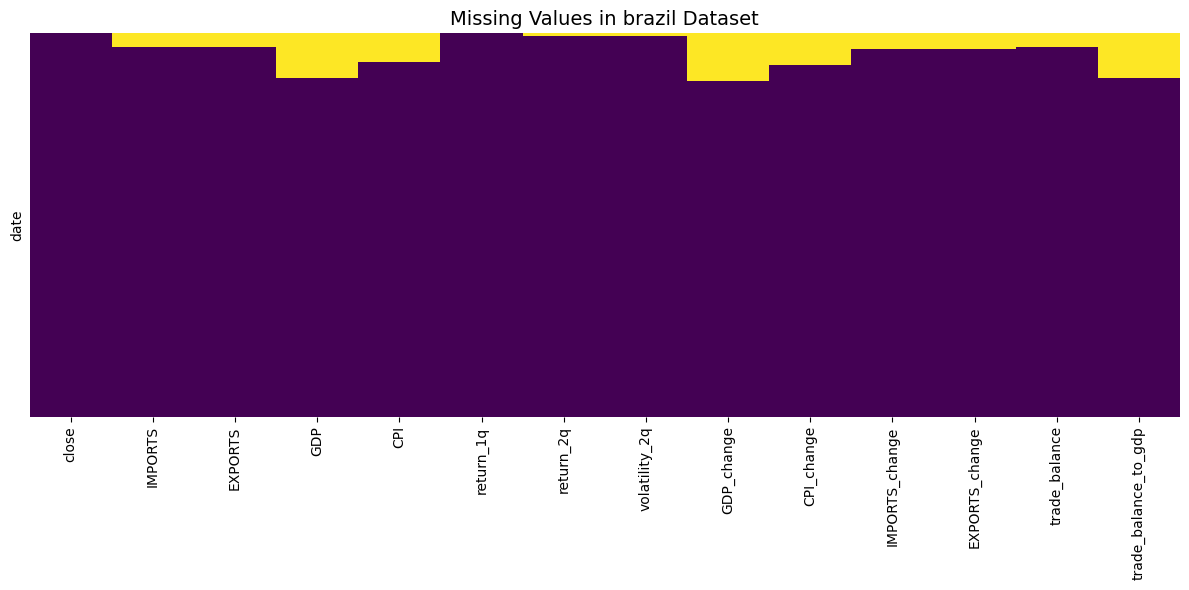


3. Descriptive Statistics:
               close     IMPORTS     EXPORTS            GDP         CPI  \
count     145.000000  140.000000  140.000000     128.000000  134.000000   
mean    87301.110552   10.284655   12.807100  305455.211182    1.462186   
std     29063.684303    1.885801    2.832574   15466.462936    0.890721   
min     40406.000000    7.190162    8.745587  270496.500000   -0.417887   
25%     55910.000000    9.337528   10.280814  294974.593750    0.836184   
50%     93952.000000    9.880815   12.300463  302607.593750    1.491117   
75%    113142.000000   11.235397   14.965250  314590.031250    1.964029   
max    136004.000000   14.849162   18.101351  337356.312500    3.222384   

        return_1q   return_2q  volatility_2q  GDP_change  CPI_change  \
count  145.000000  144.000000     144.000000  127.000000  133.000000   
mean     0.007791    0.016127       0.046431    0.000796    0.003080   
std      0.062962    0.093555       0.039129    0.012149    0.563819   
min     

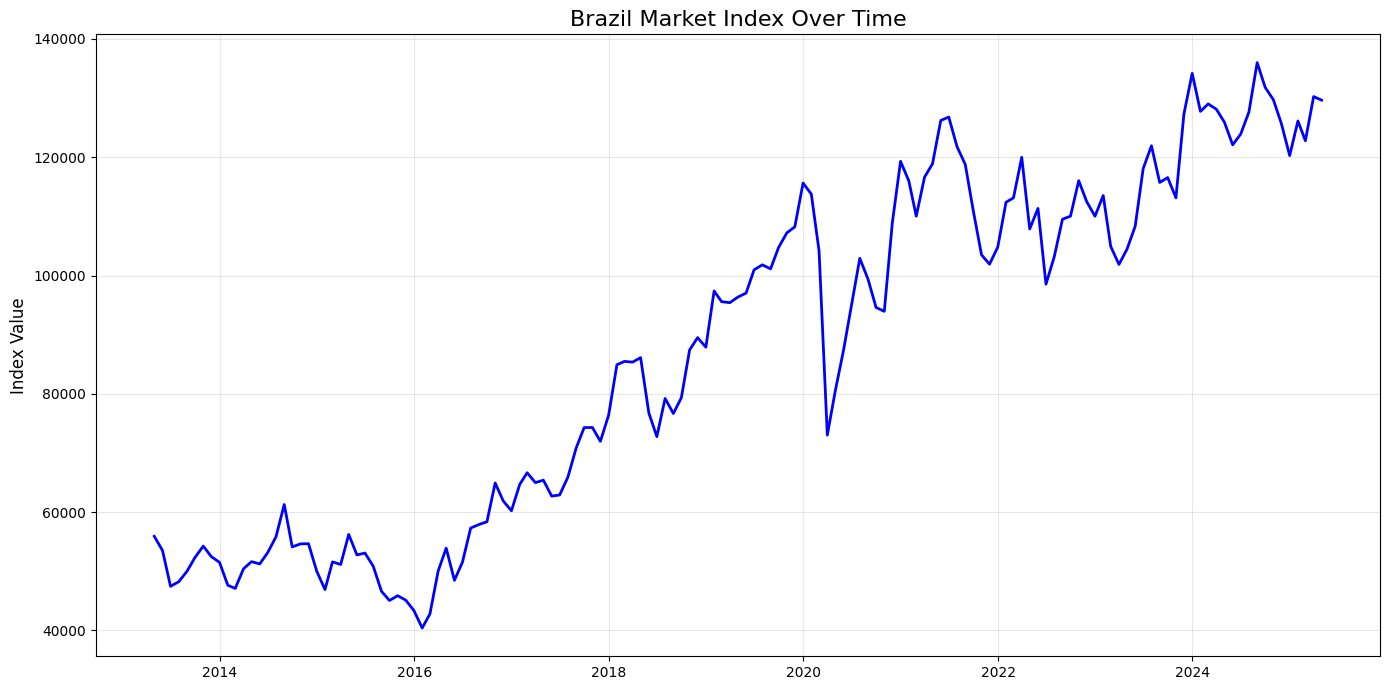


4. Correlation Analysis:


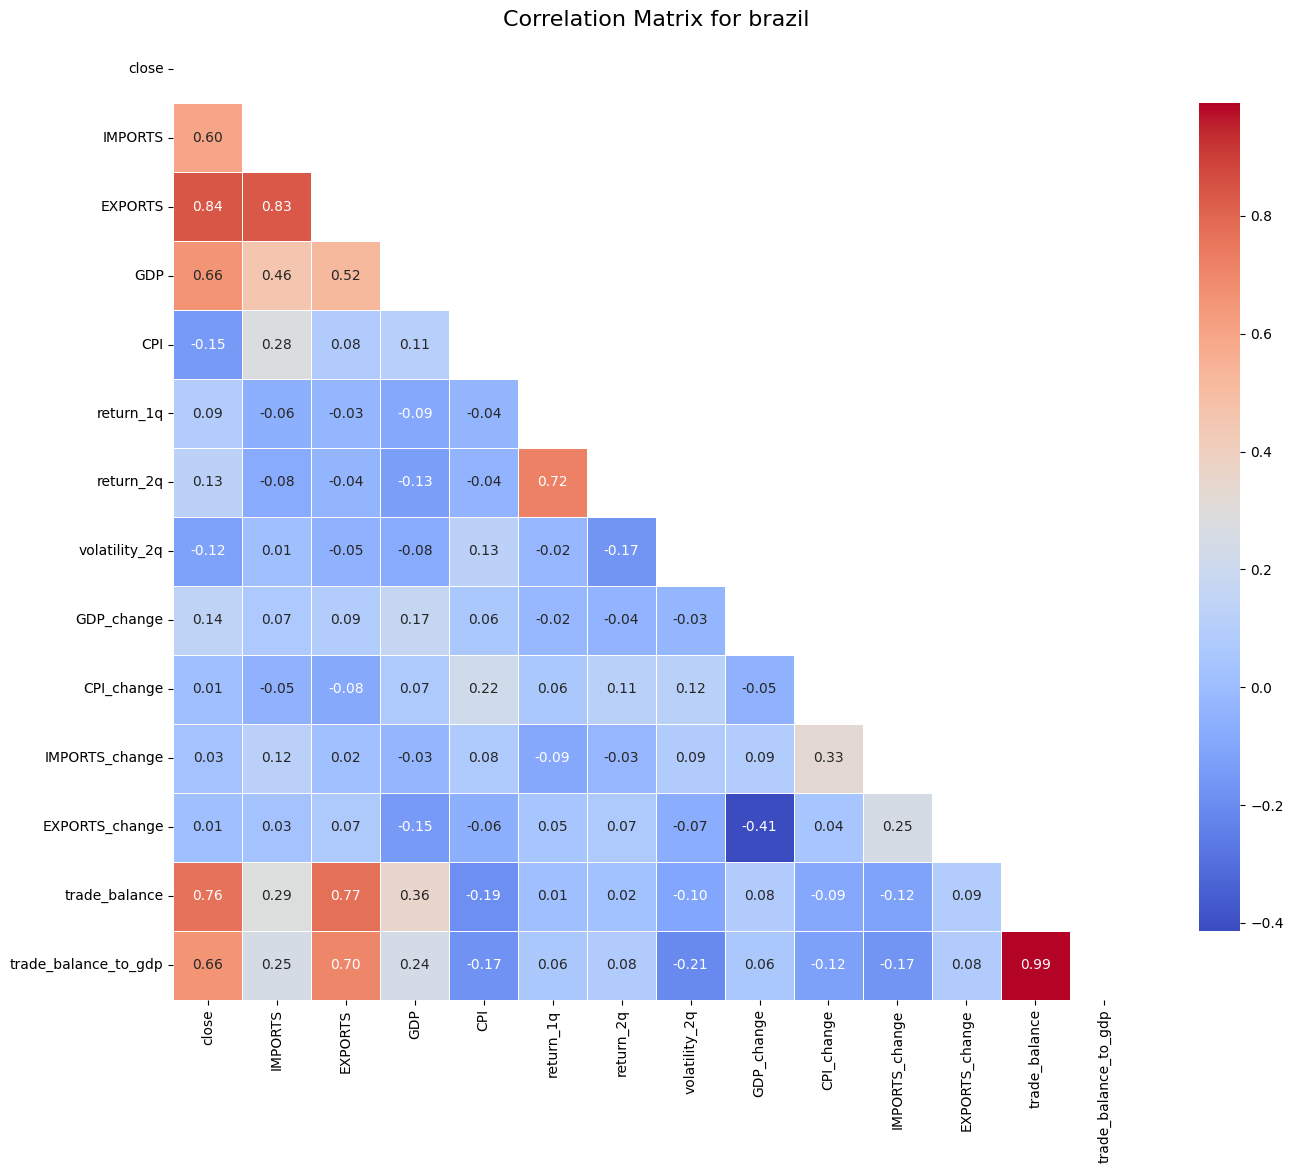


Highly correlated feature pairs (|r| > 0.8):
 - close and EXPORTS: 0.840
 - IMPORTS and EXPORTS: 0.833
 - trade_balance and trade_balance_to_gdp: 0.991

5. Feature Distribution Analysis:


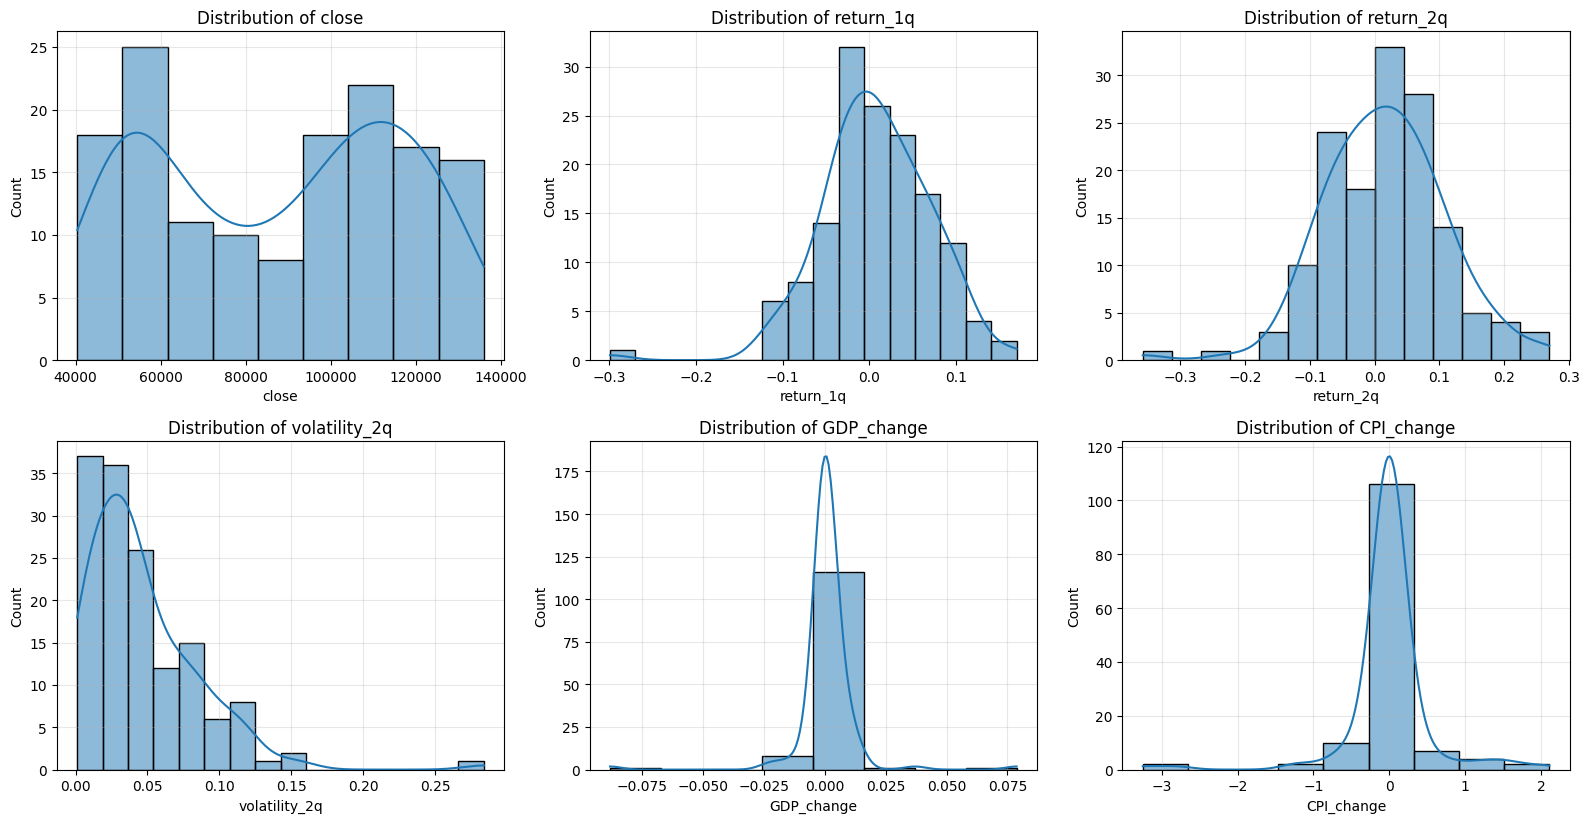


6. Time Series Decomposition:


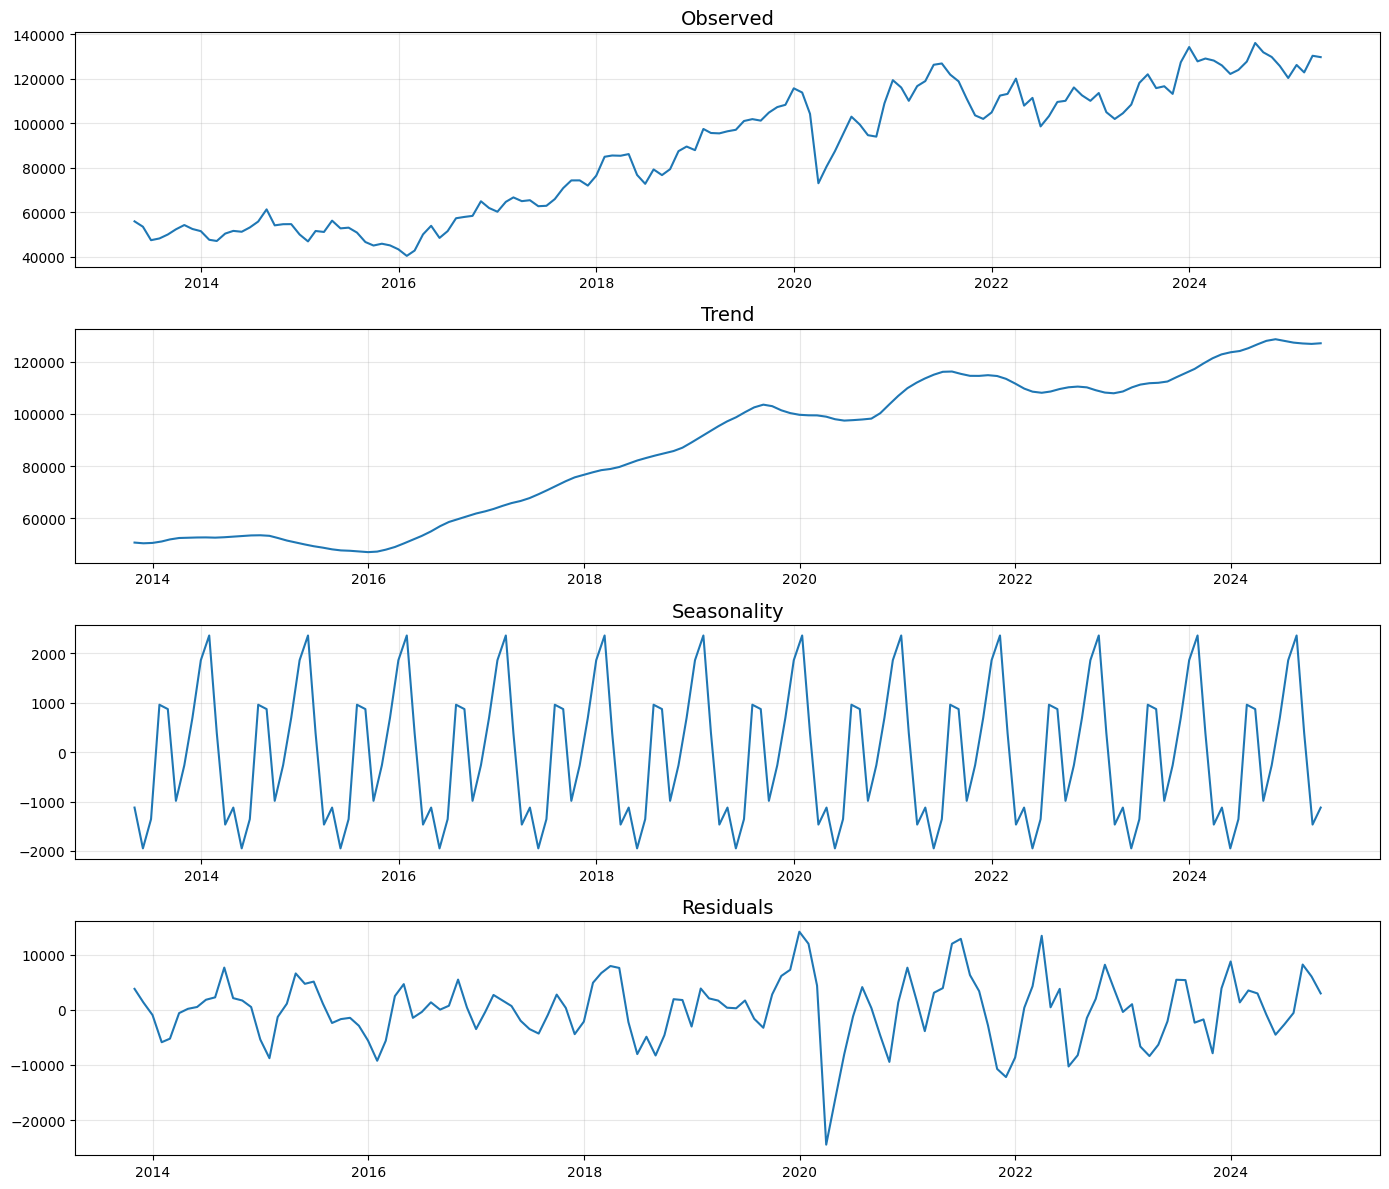


7. Return Distribution and Volatility Analysis:


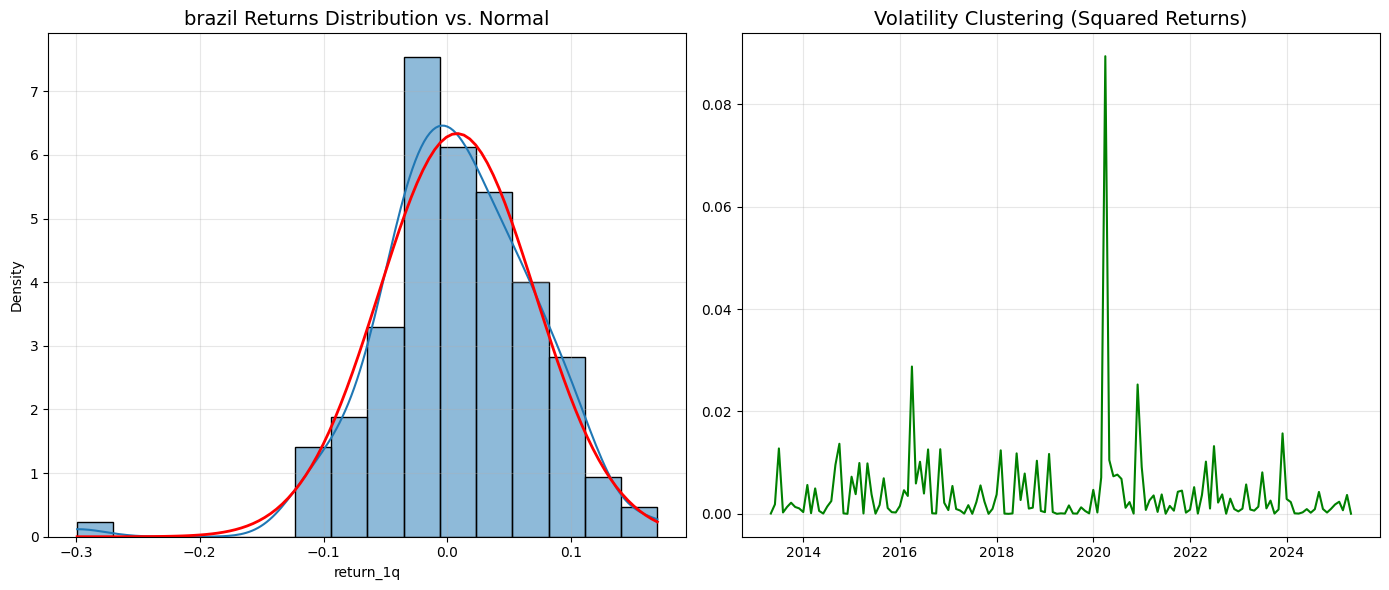

Return Statistics:
 - Mean: 0.0078
 - Standard Deviation: 0.0630
 - Skewness: -0.6181
 - Kurtosis: 2.9158
 - Min: -0.2990
 - Max: 0.1697

Exploratory Data Analysis Complete.

Regime distribution:
regime
2    75
0    36
1    34
Name: count, dtype: int64


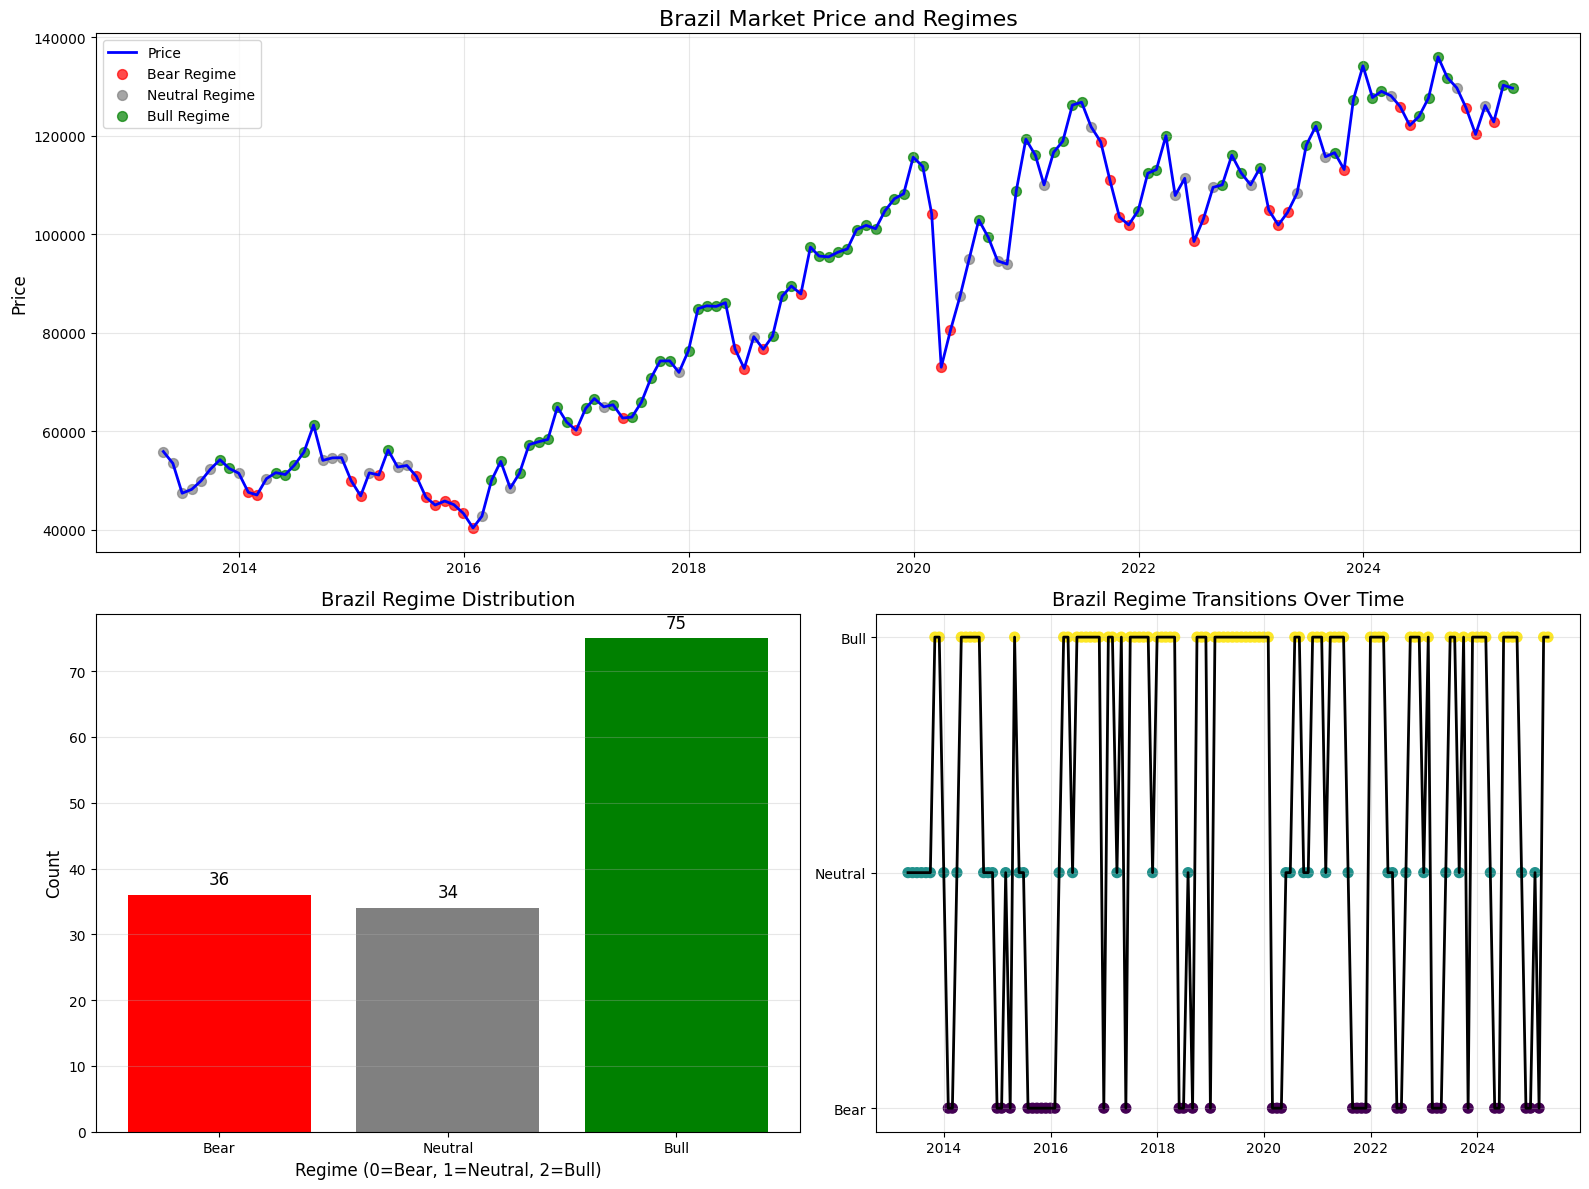

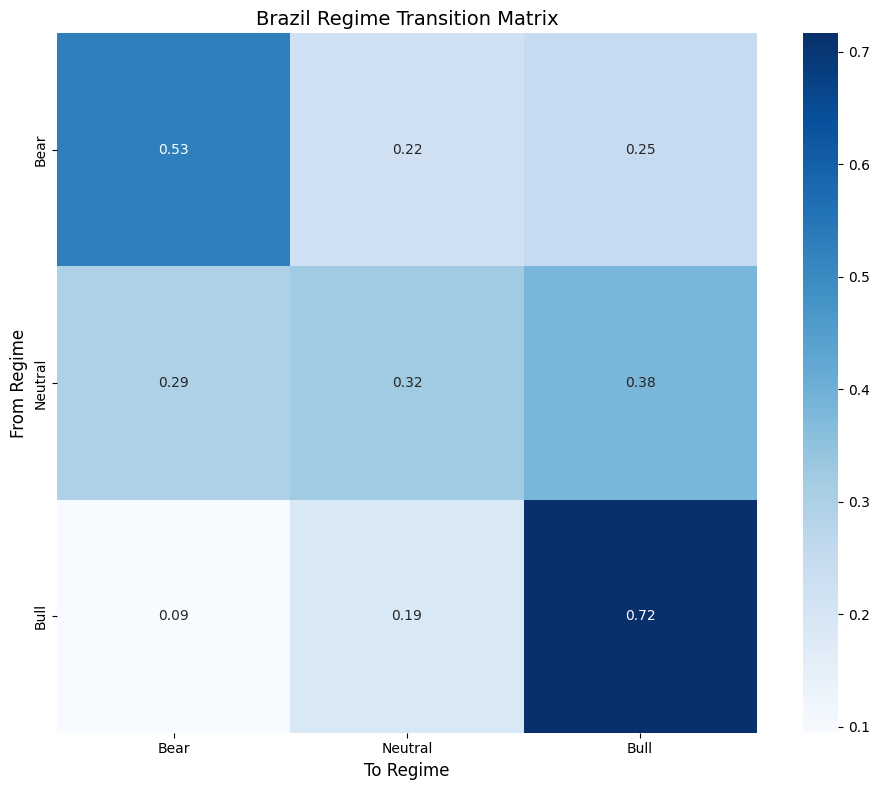


PROCESSING INDIA
Processing india...
Successfully processed india data: 146 rows, 5 columns
Date range: 2013-03-31 00:00:00 to 2025-04-30 00:00:00
Engineered features. Shape: (145, 14)

EXPLORATORY DATA ANALYSIS FOR INDIA

1. Data Structure Check:
 - Data shape: (145, 14)
 - Columns: ['close', 'IMPORTS', 'EXPORTS', 'GDP', 'CPI', 'return_1q', 'return_2q', 'volatility_2q', 'GDP_change', 'CPI_change', 'IMPORTS_change', 'EXPORTS_change', 'trade_balance', 'trade_balance_to_gdp']
 - Date range: 2013-04-30 00:00:00 to 2025-04-30 00:00:00

2. Data Quality Assessment:
 - Columns with missing values: {'IMPORTS': 5, 'EXPORTS': 5, 'GDP': 20, 'CPI': 20, 'return_2q': 1, 'volatility_2q': 1, 'GDP_change': 21, 'CPI_change': 21, 'IMPORTS_change': 6, 'EXPORTS_change': 6, 'trade_balance': 5, 'trade_balance_to_gdp': 20}


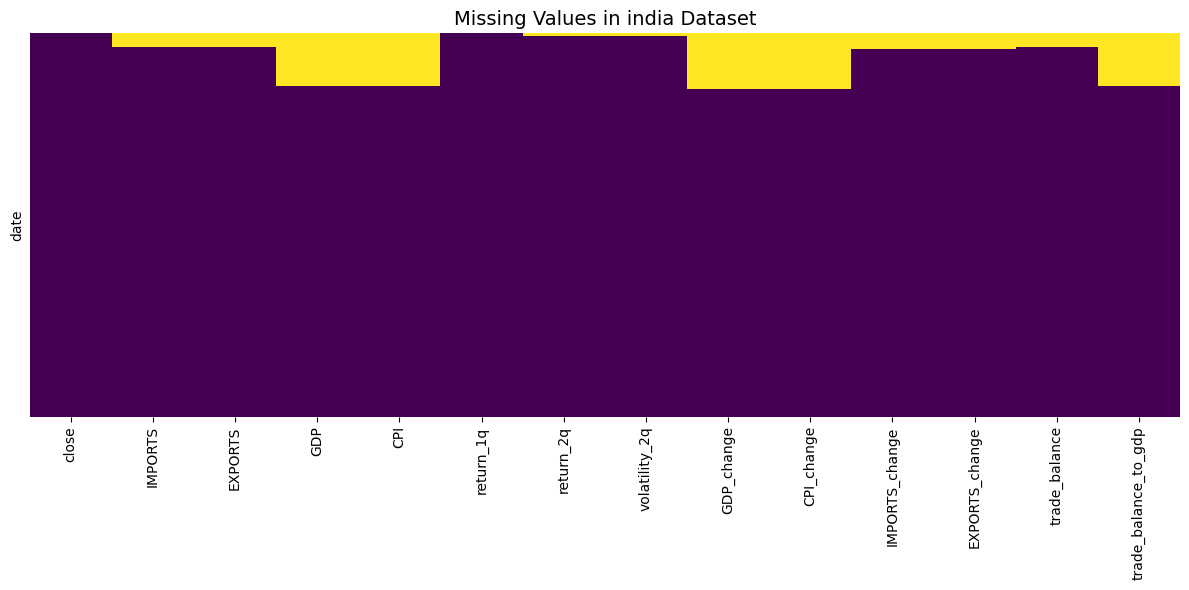


3. Descriptive Statistics:
              close     IMPORTS     EXPORTS           GDP         CPI  \
count    145.000000  140.000000  140.000000  1.250000e+02  125.000000   
mean   12838.769310   18.756723   12.726459  3.602583e+07  125.629774   
std     5441.609684    2.593608    1.770680  5.925593e+06   19.527517   
min     5471.800000   12.010055   10.126270  2.645950e+07   96.780360   
25%     8491.000000   17.622094   11.698334  3.146340e+07  106.471200   
50%    11023.250000   18.850846   12.259870  3.549950e+07  125.342700   
75%    17303.950000   19.782026   13.208869  4.057580e+07  143.743000   
max    25810.850000   24.501130   18.211699  4.782030e+07  158.910500   

        return_1q   return_2q  volatility_2q  GDP_change  CPI_change  \
count  145.000000  144.000000     144.000000  124.000000  124.000000   
mean     0.011085    0.021861       0.034545    0.005740    0.004043   
std      0.045829    0.063906       0.031773    0.045043    0.008506   
min     -0.232464   -0.281

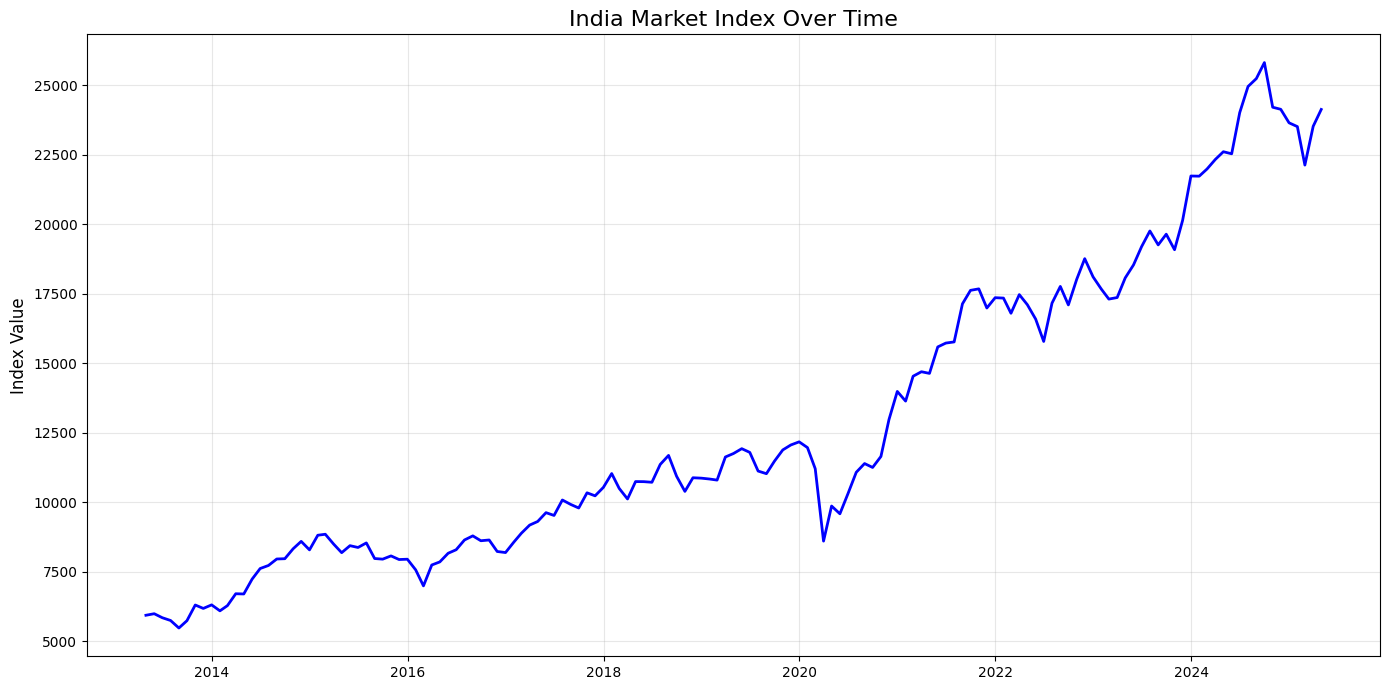


4. Correlation Analysis:


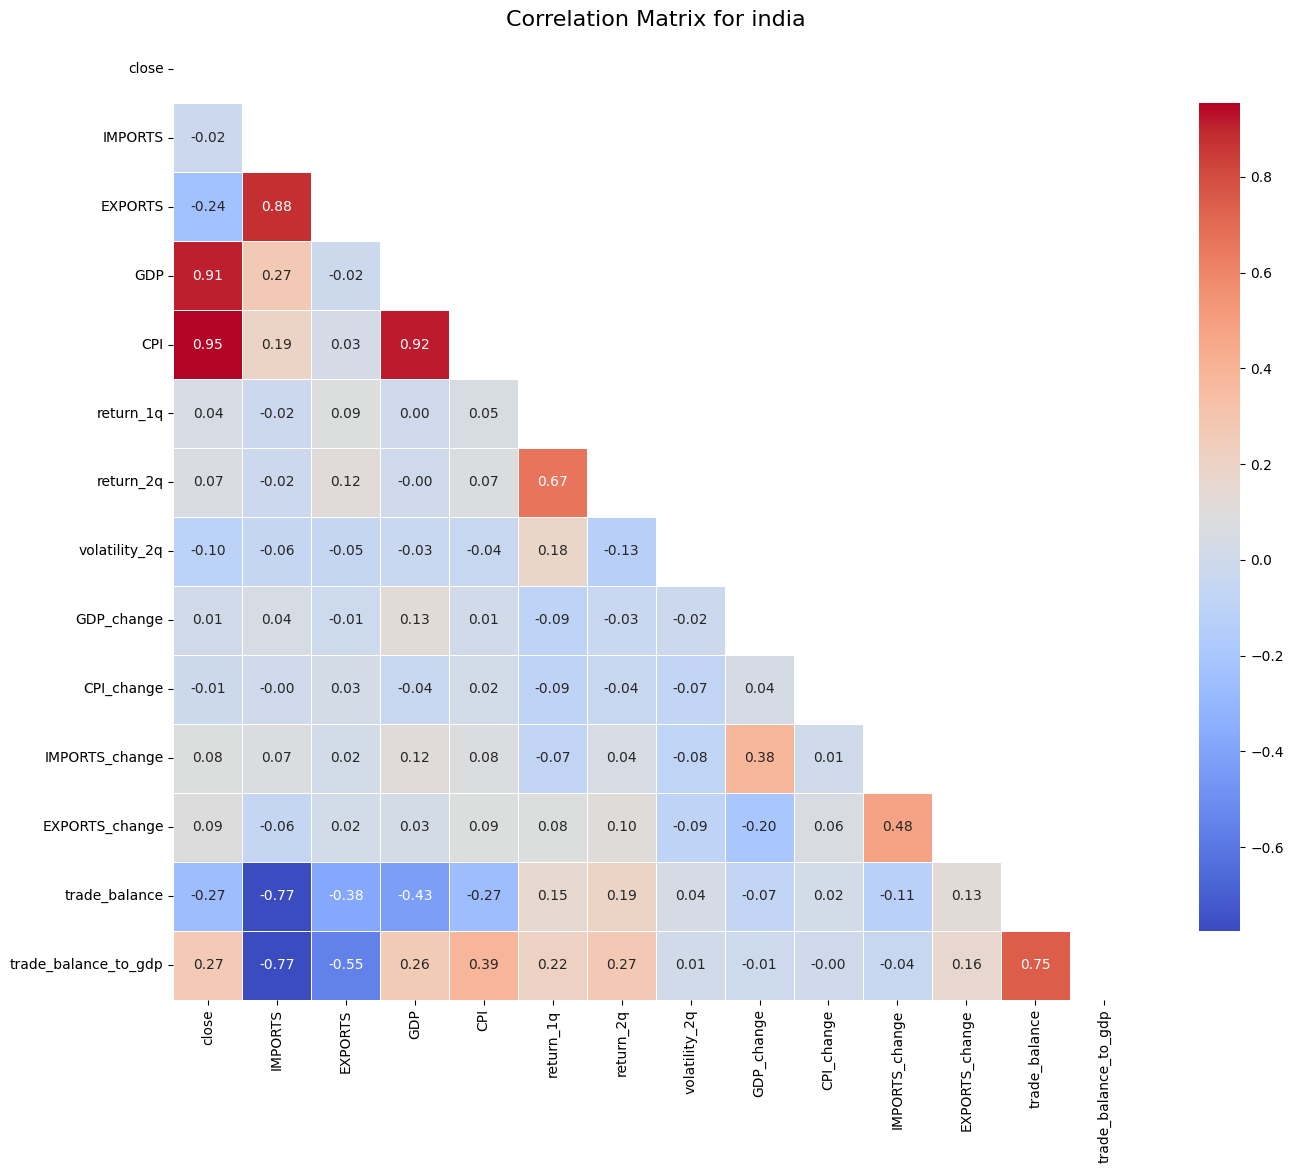


Highly correlated feature pairs (|r| > 0.8):
 - close and GDP: 0.910
 - close and CPI: 0.954
 - IMPORTS and EXPORTS: 0.878
 - GDP and CPI: 0.920

5. Feature Distribution Analysis:


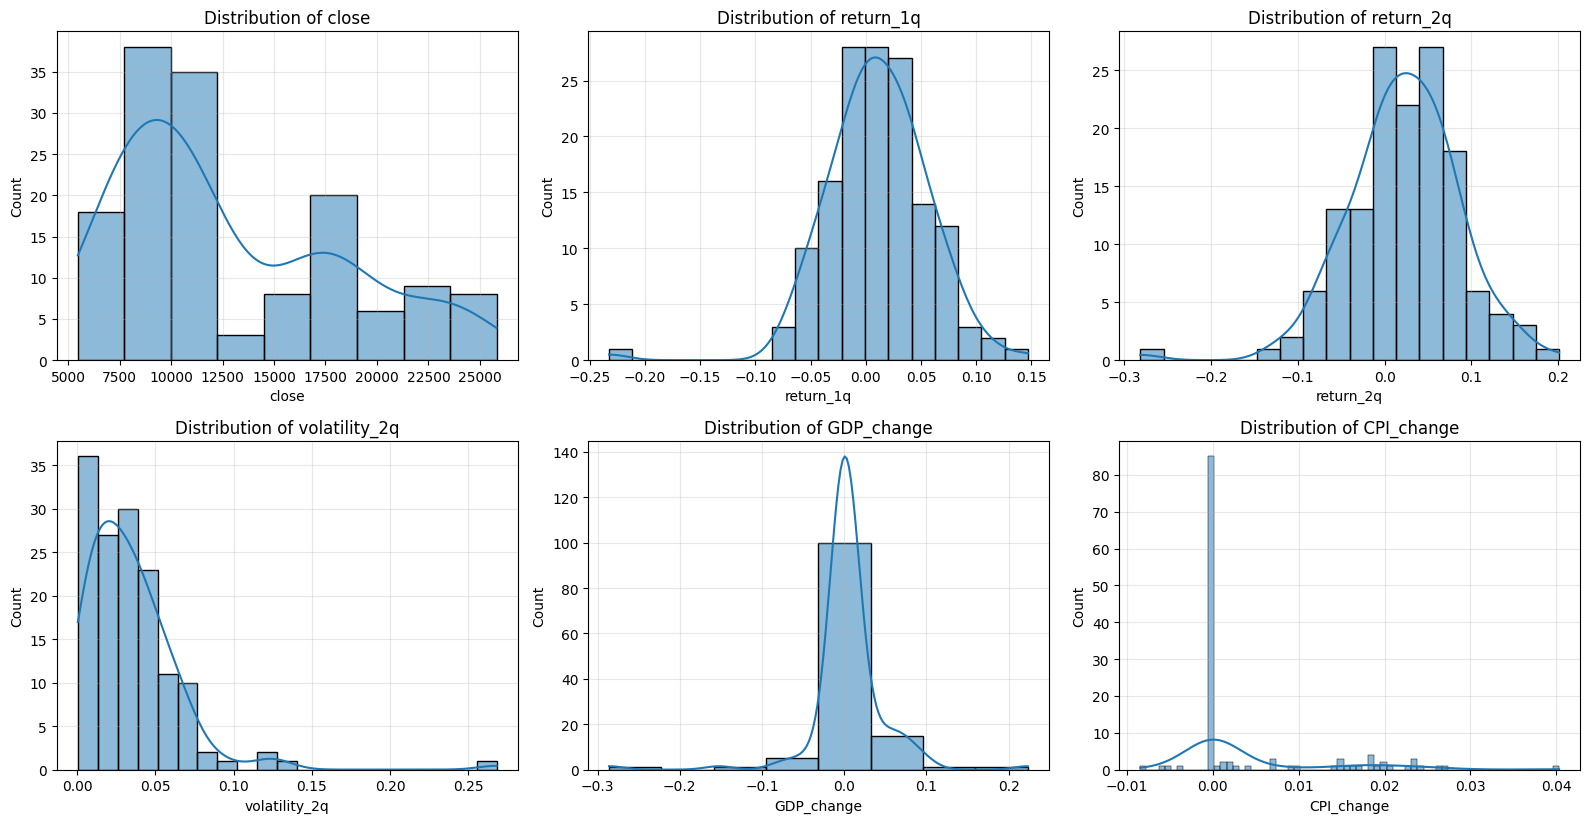


6. Time Series Decomposition:


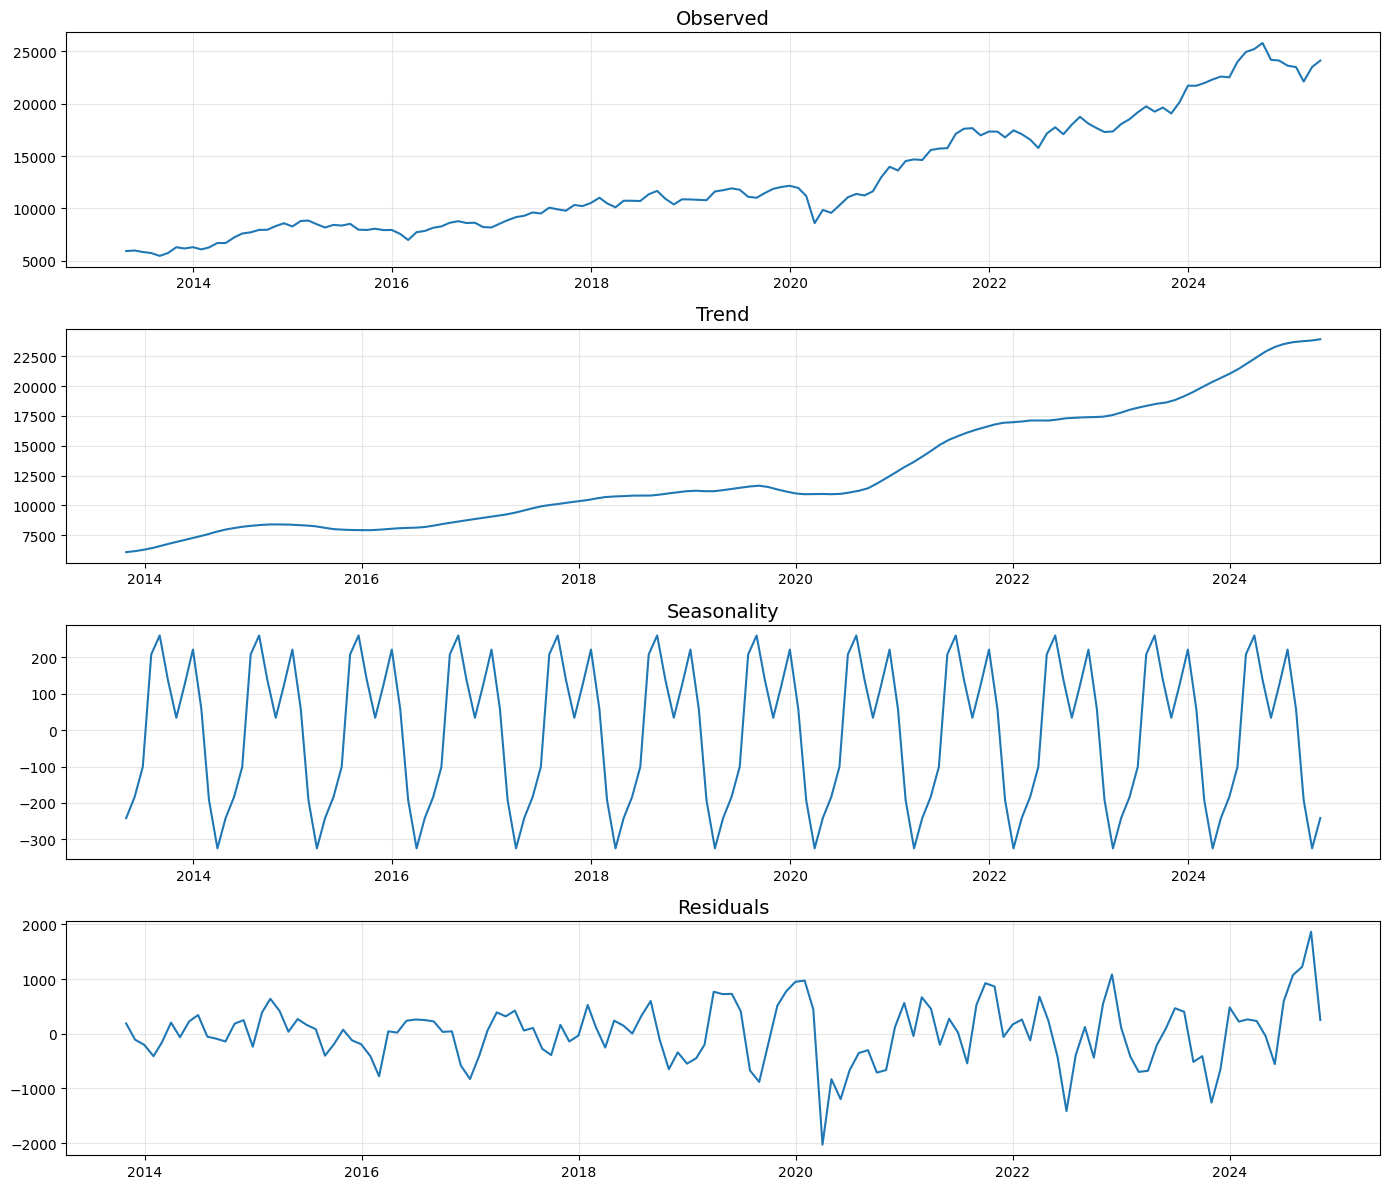


7. Return Distribution and Volatility Analysis:


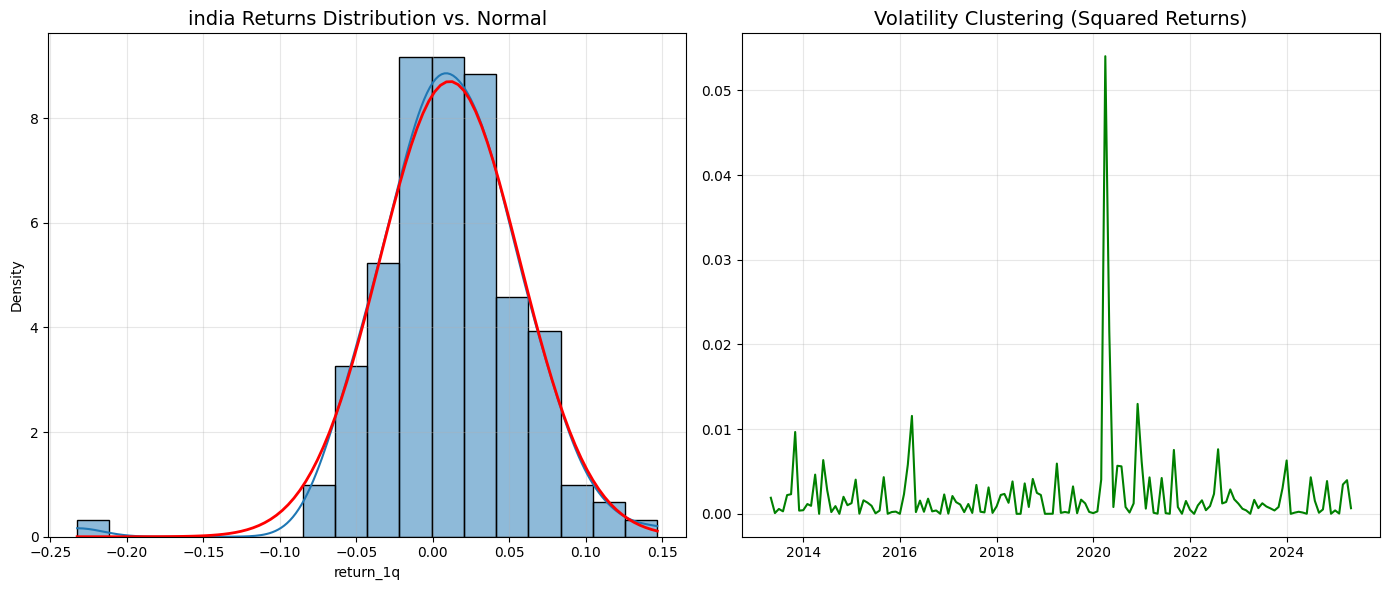

Return Statistics:
 - Mean: 0.0111
 - Standard Deviation: 0.0458
 - Skewness: -0.7513
 - Kurtosis: 4.5655
 - Min: -0.2325
 - Max: 0.1468

Exploratory Data Analysis Complete.

Regime distribution:
regime
2    81
1    35
0    29
Name: count, dtype: int64


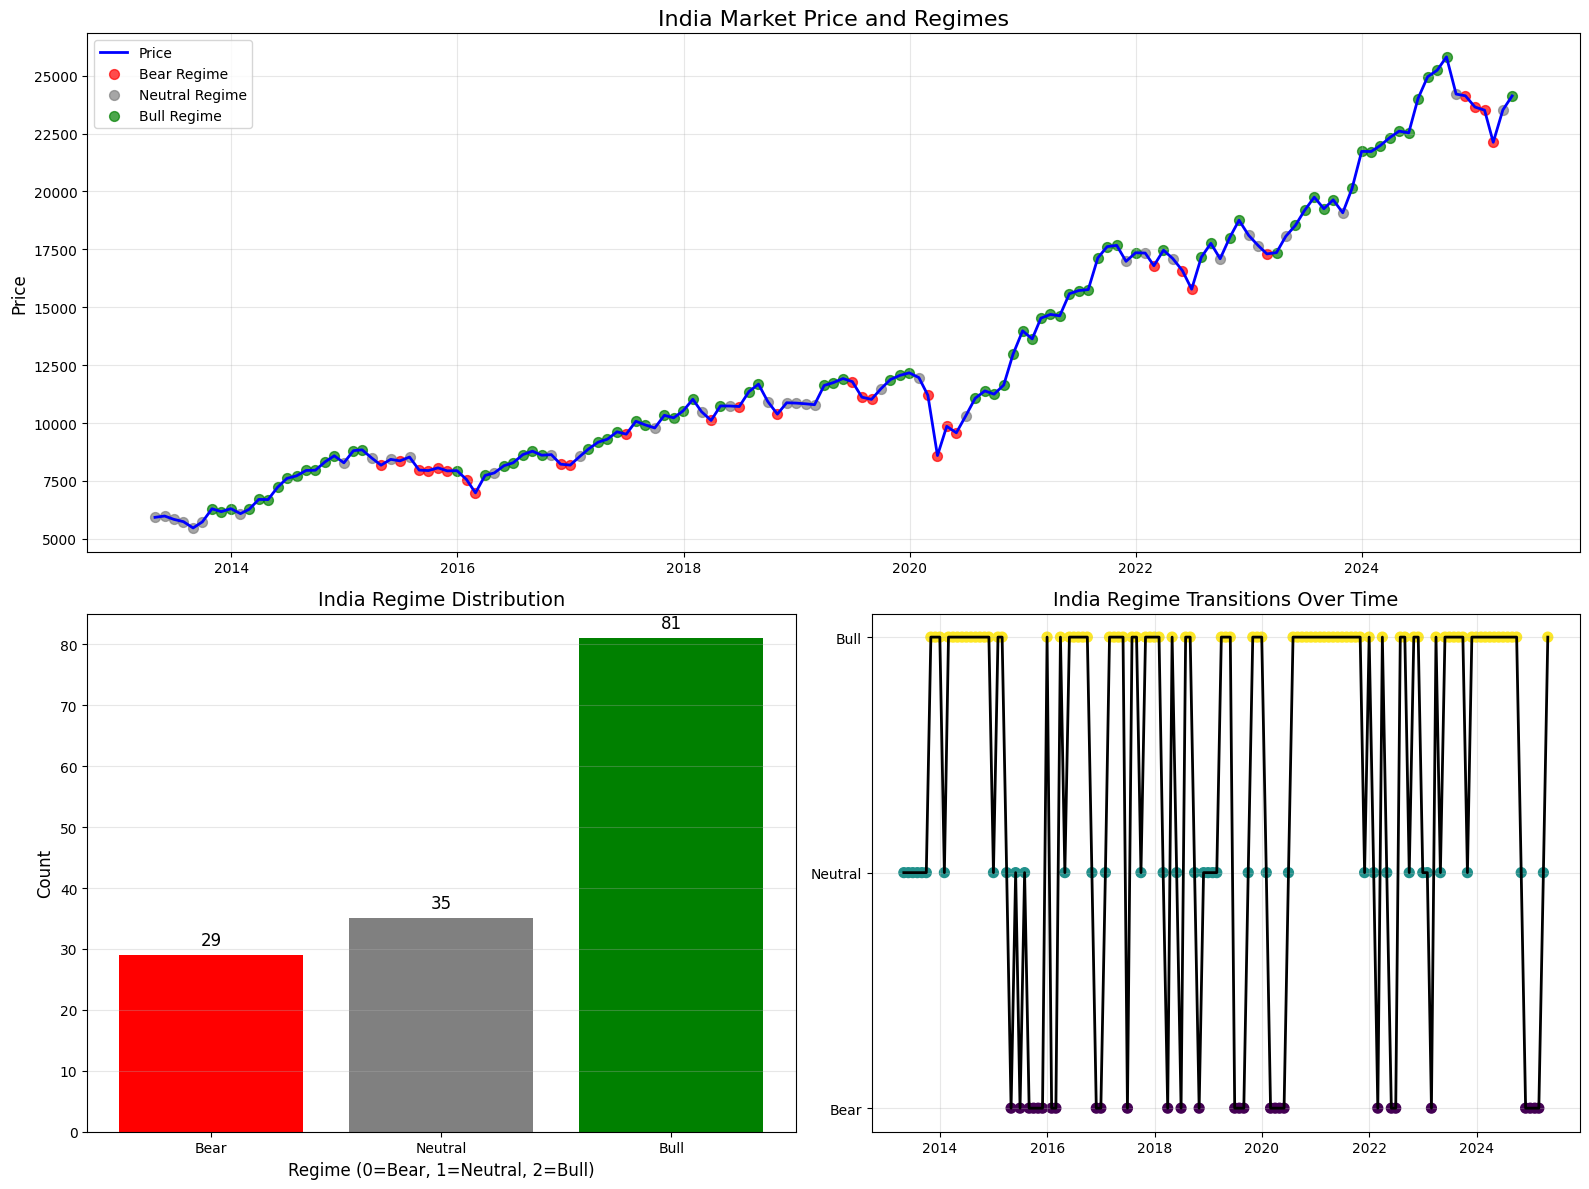

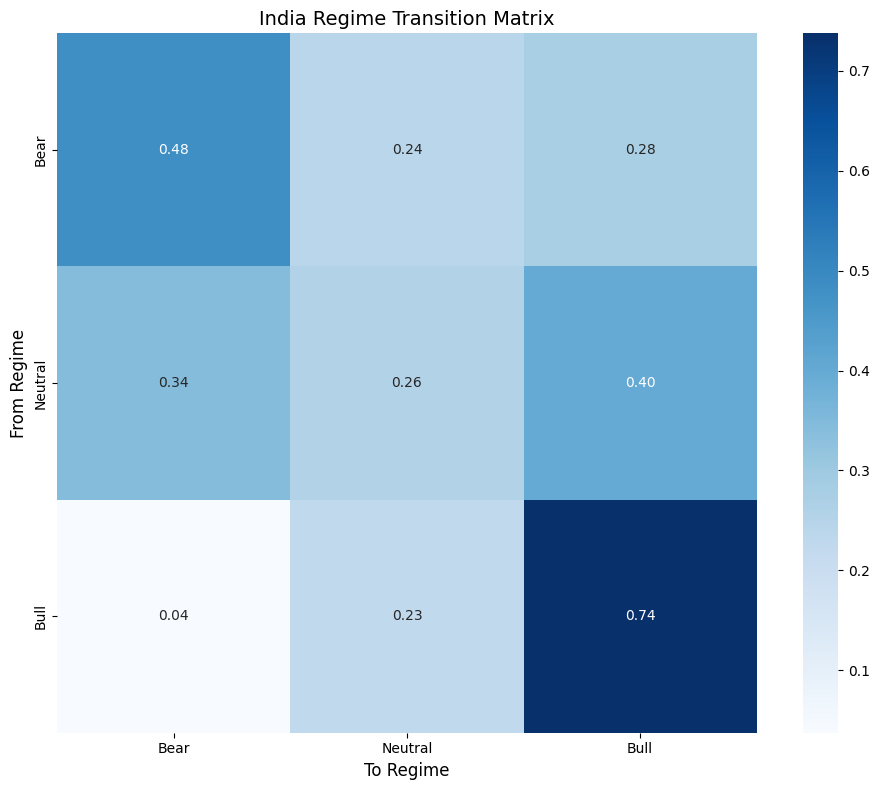


PROCESSING SOUTH_AFRICA
Processing south_africa...
Successfully processed south_africa data: 146 rows, 6 columns
Date range: 2013-03-31 00:00:00 to 2025-04-30 00:00:00
Engineered features. Shape: (145, 16)

EXPLORATORY DATA ANALYSIS FOR SOUTH_AFRICA

1. Data Structure Check:
 - Data shape: (145, 16)
 - Columns: ['close', 'UNEMPLOYMENT', 'GDP', 'IMPORTS', 'EXPORTS', 'CPI', 'return_1q', 'return_2q', 'volatility_2q', 'GDP_change', 'CPI_change', 'UNEMPLOYMENT_change', 'IMPORTS_change', 'EXPORTS_change', 'trade_balance', 'trade_balance_to_gdp']
 - Date range: 2013-04-30 00:00:00 to 2025-04-30 00:00:00

2. Data Quality Assessment:
 - Columns with missing values: {'UNEMPLOYMENT': 20, 'GDP': 20, 'IMPORTS': 5, 'EXPORTS': 5, 'CPI': 8, 'return_2q': 1, 'volatility_2q': 1, 'GDP_change': 21, 'CPI_change': 9, 'UNEMPLOYMENT_change': 21, 'IMPORTS_change': 6, 'EXPORTS_change': 6, 'trade_balance': 5, 'trade_balance_to_gdp': 20}


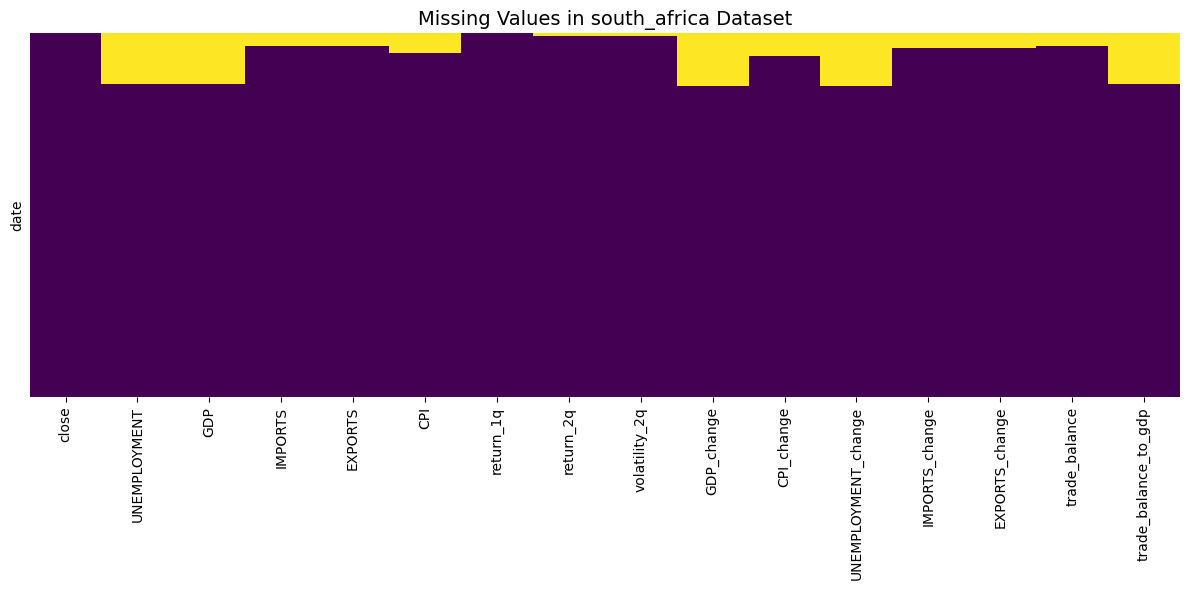


3. Descriptive Statistics:
            close  UNEMPLOYMENT           GDP     IMPORTS     EXPORTS  \
count  145.000000  1.250000e+02  1.250000e+02  140.000000  140.000000   
mean    38.766276  3.291954e+06  1.130774e+06   24.365489   25.805648   
std      4.823151  5.212847e+05  3.532168e+04    2.669227    3.044070   
min     22.980000  2.144860e+06  9.538462e+05   19.071814   22.101774   
25%     36.050000  2.898622e+06  1.113451e+06   22.319764   23.138288   
50%     38.630000  3.212917e+06  1.137294e+06   24.216191   24.207924   
75%     41.980000  3.832671e+06  1.151605e+06   27.086328   29.356312   
max     49.850000  4.120901e+06  1.169859e+06   30.260683   31.108380   

              CPI   return_1q   return_2q  volatility_2q  GDP_change  \
count  137.000000  145.000000  144.000000     144.000000  124.000000   
mean     1.288811    0.004029    0.007715       0.058408    0.000704   
std      0.605498    0.071079    0.096791       0.045915    0.020223   
min     -0.252161   -0.295

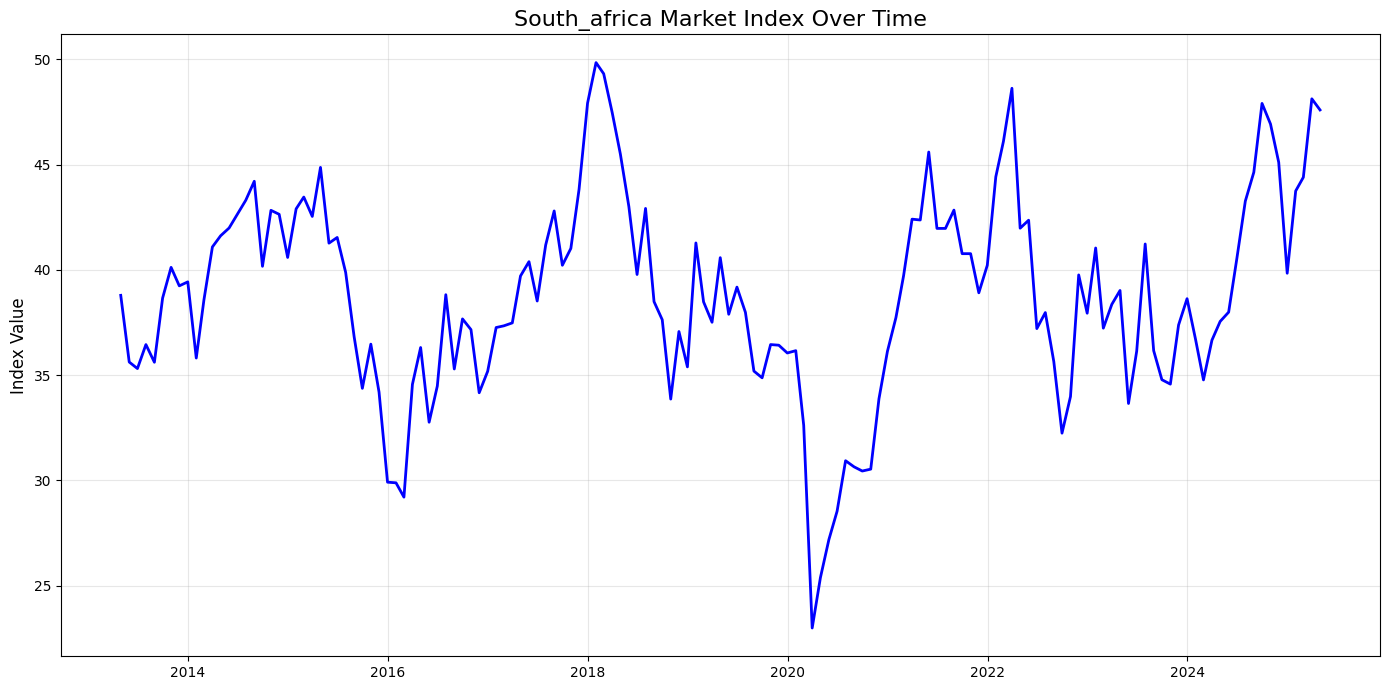


4. Correlation Analysis:


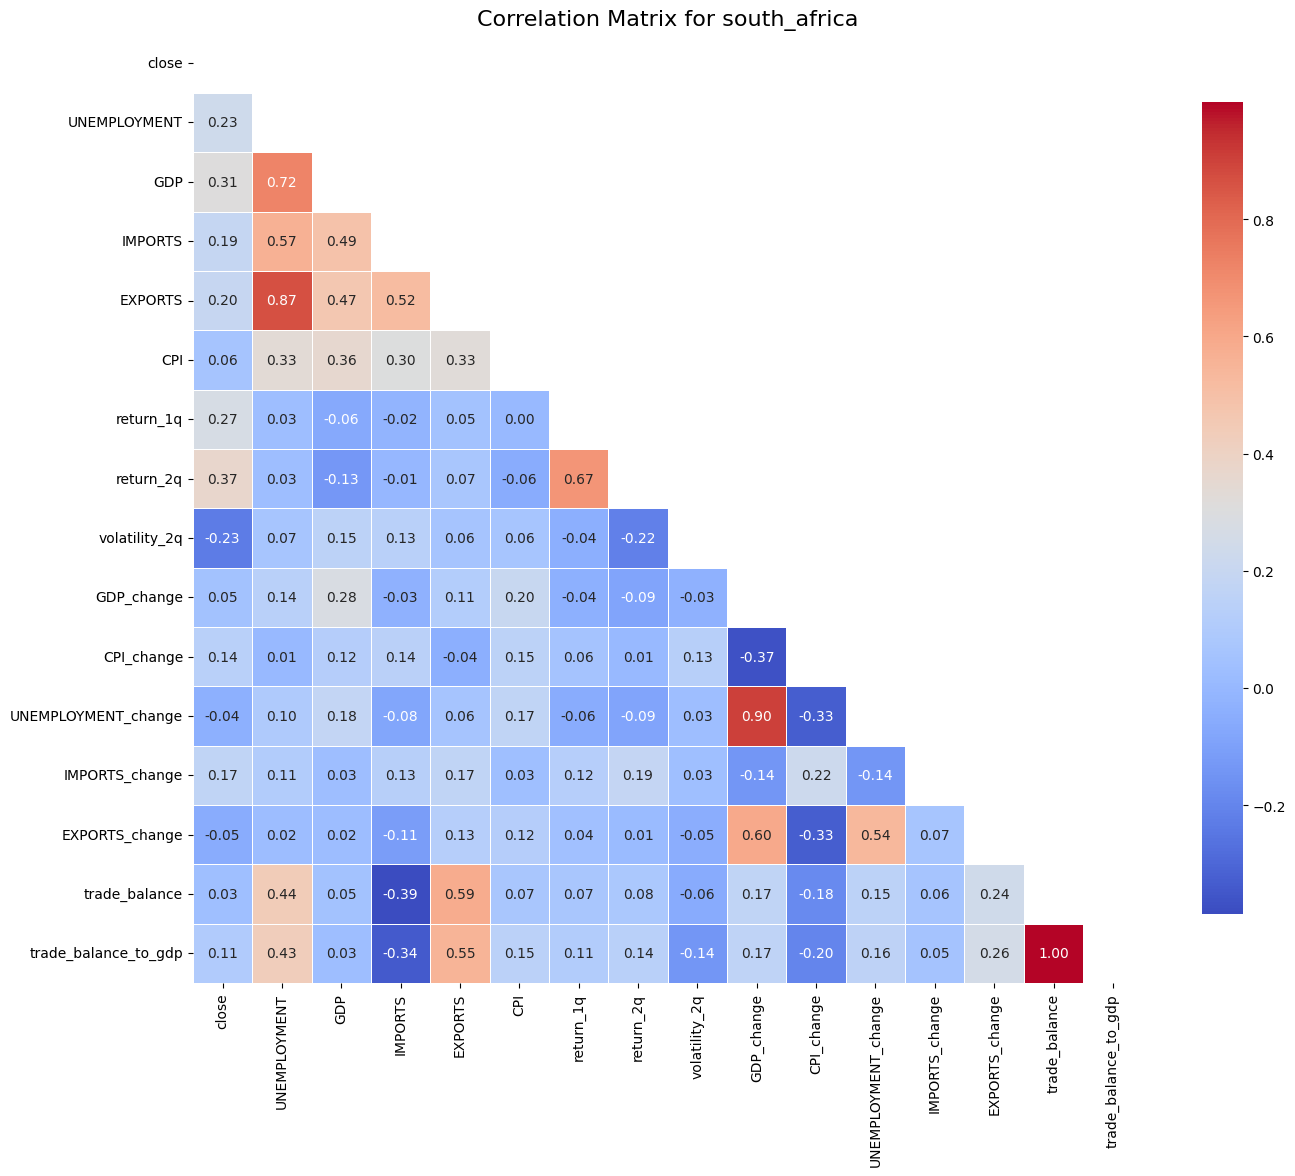


Highly correlated feature pairs (|r| > 0.8):
 - UNEMPLOYMENT and EXPORTS: 0.867
 - GDP_change and UNEMPLOYMENT_change: 0.903
 - trade_balance and trade_balance_to_gdp: 1.000

5. Feature Distribution Analysis:


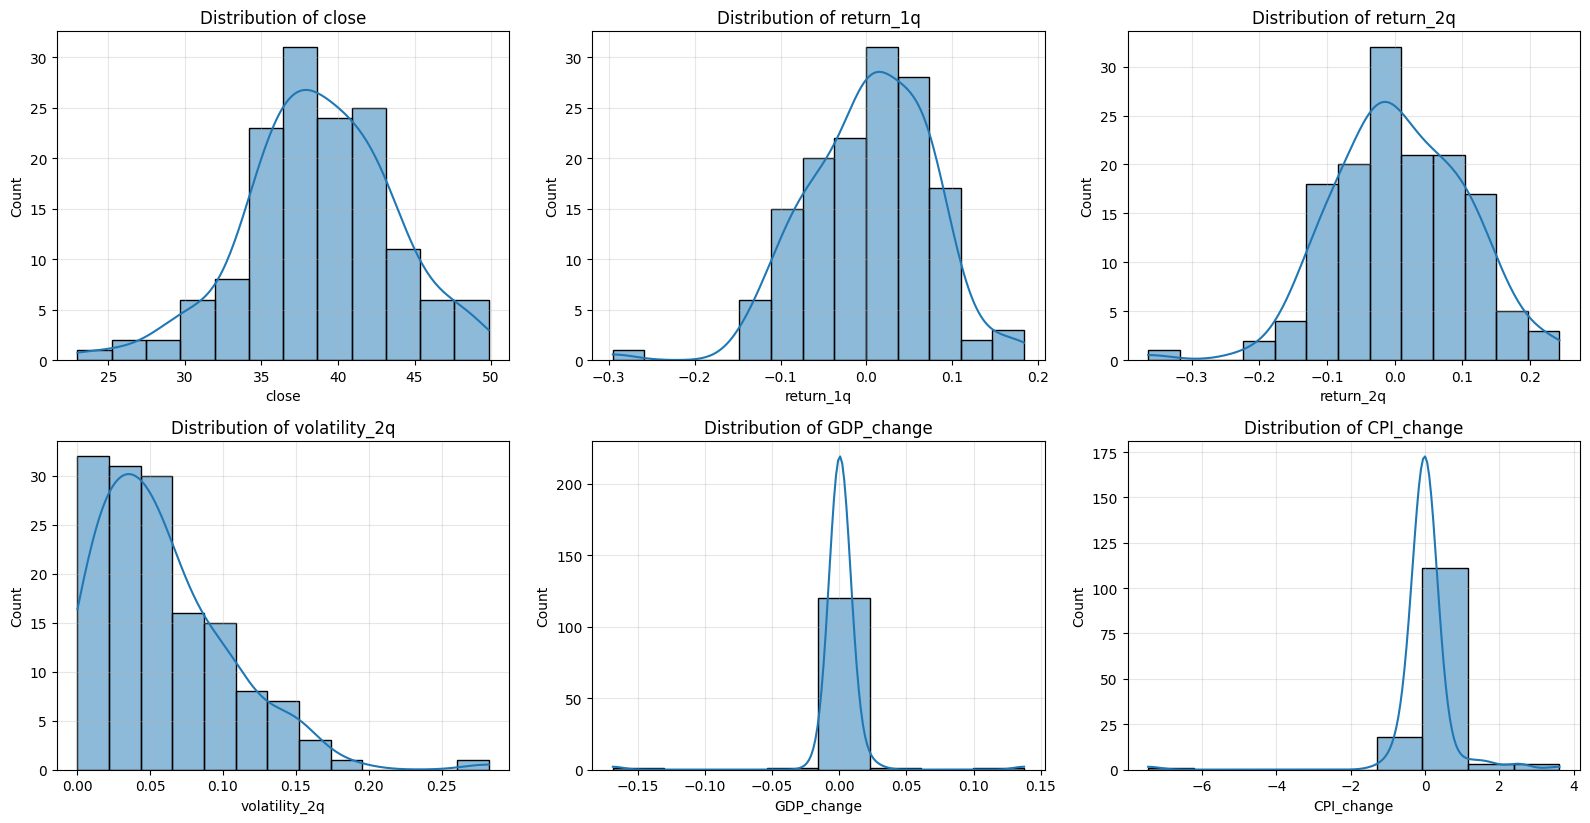


6. Time Series Decomposition:


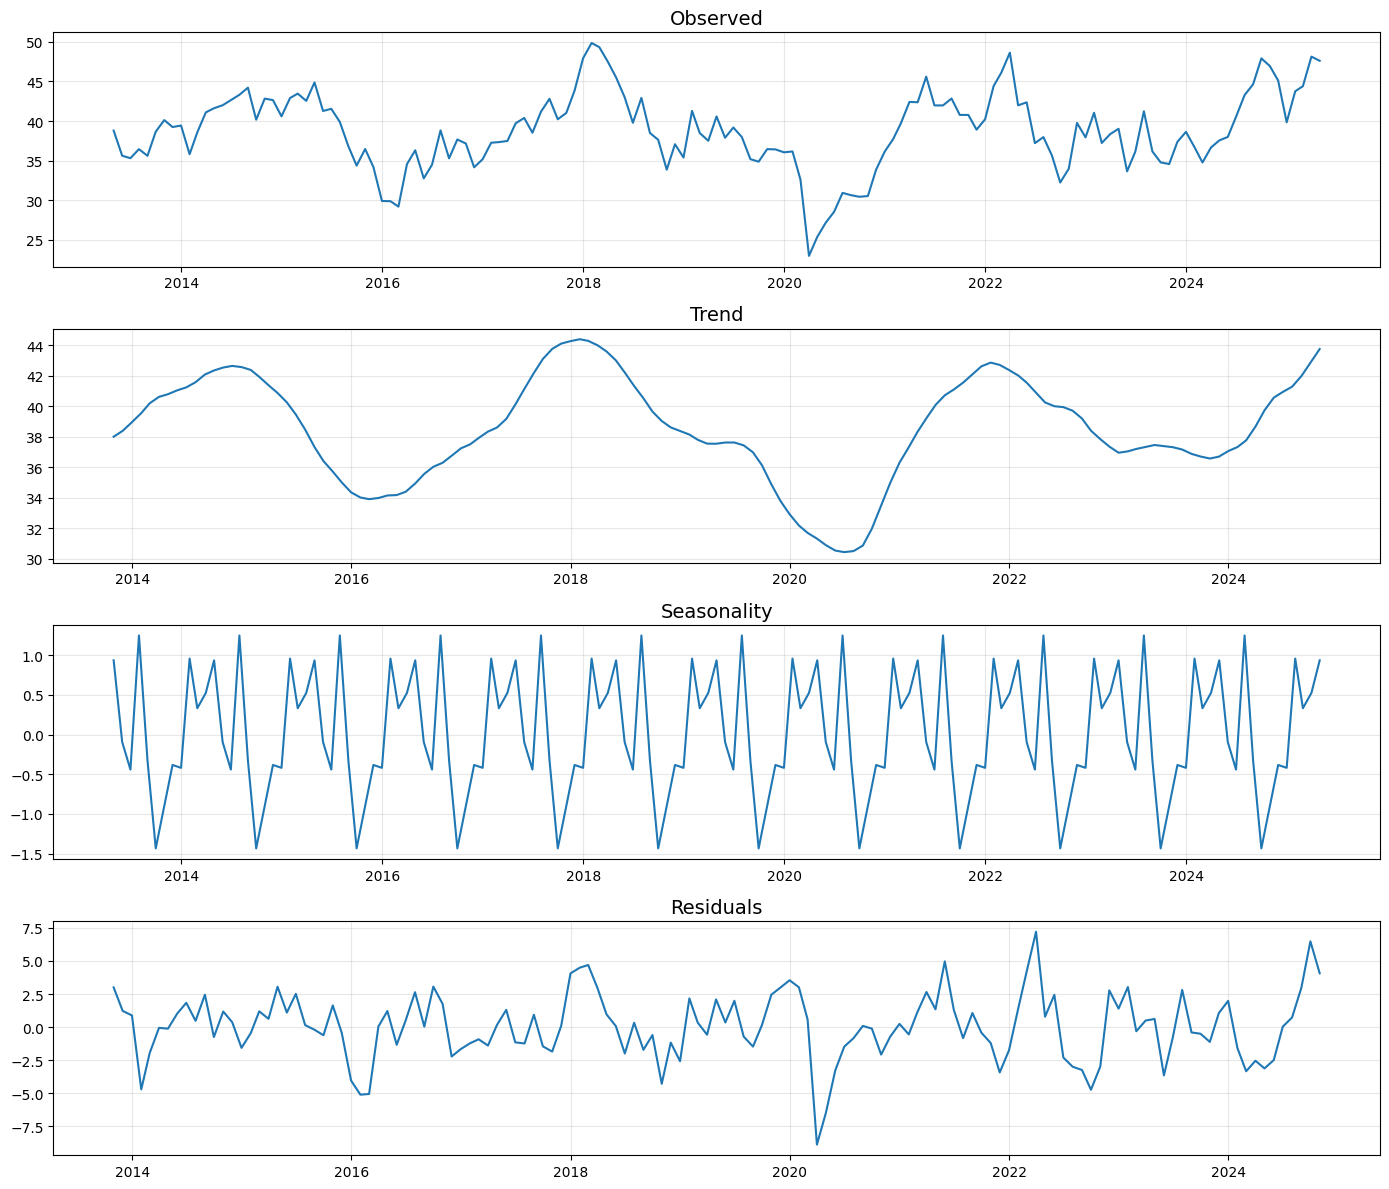


7. Return Distribution and Volatility Analysis:


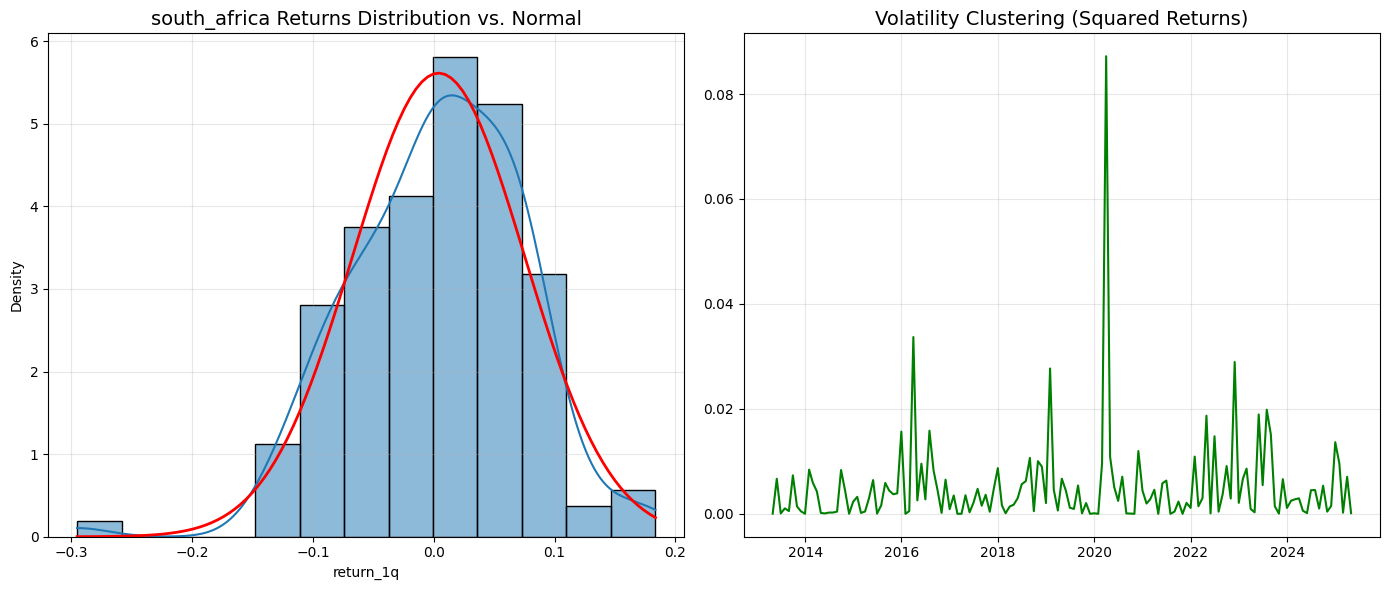

Return Statistics:
 - Mean: 0.0040
 - Standard Deviation: 0.0711
 - Skewness: -0.4485
 - Kurtosis: 1.2483
 - Min: -0.2953
 - Max: 0.1836

Exploratory Data Analysis Complete.

Regime distribution:
regime
2    63
0    46
1    36
Name: count, dtype: int64


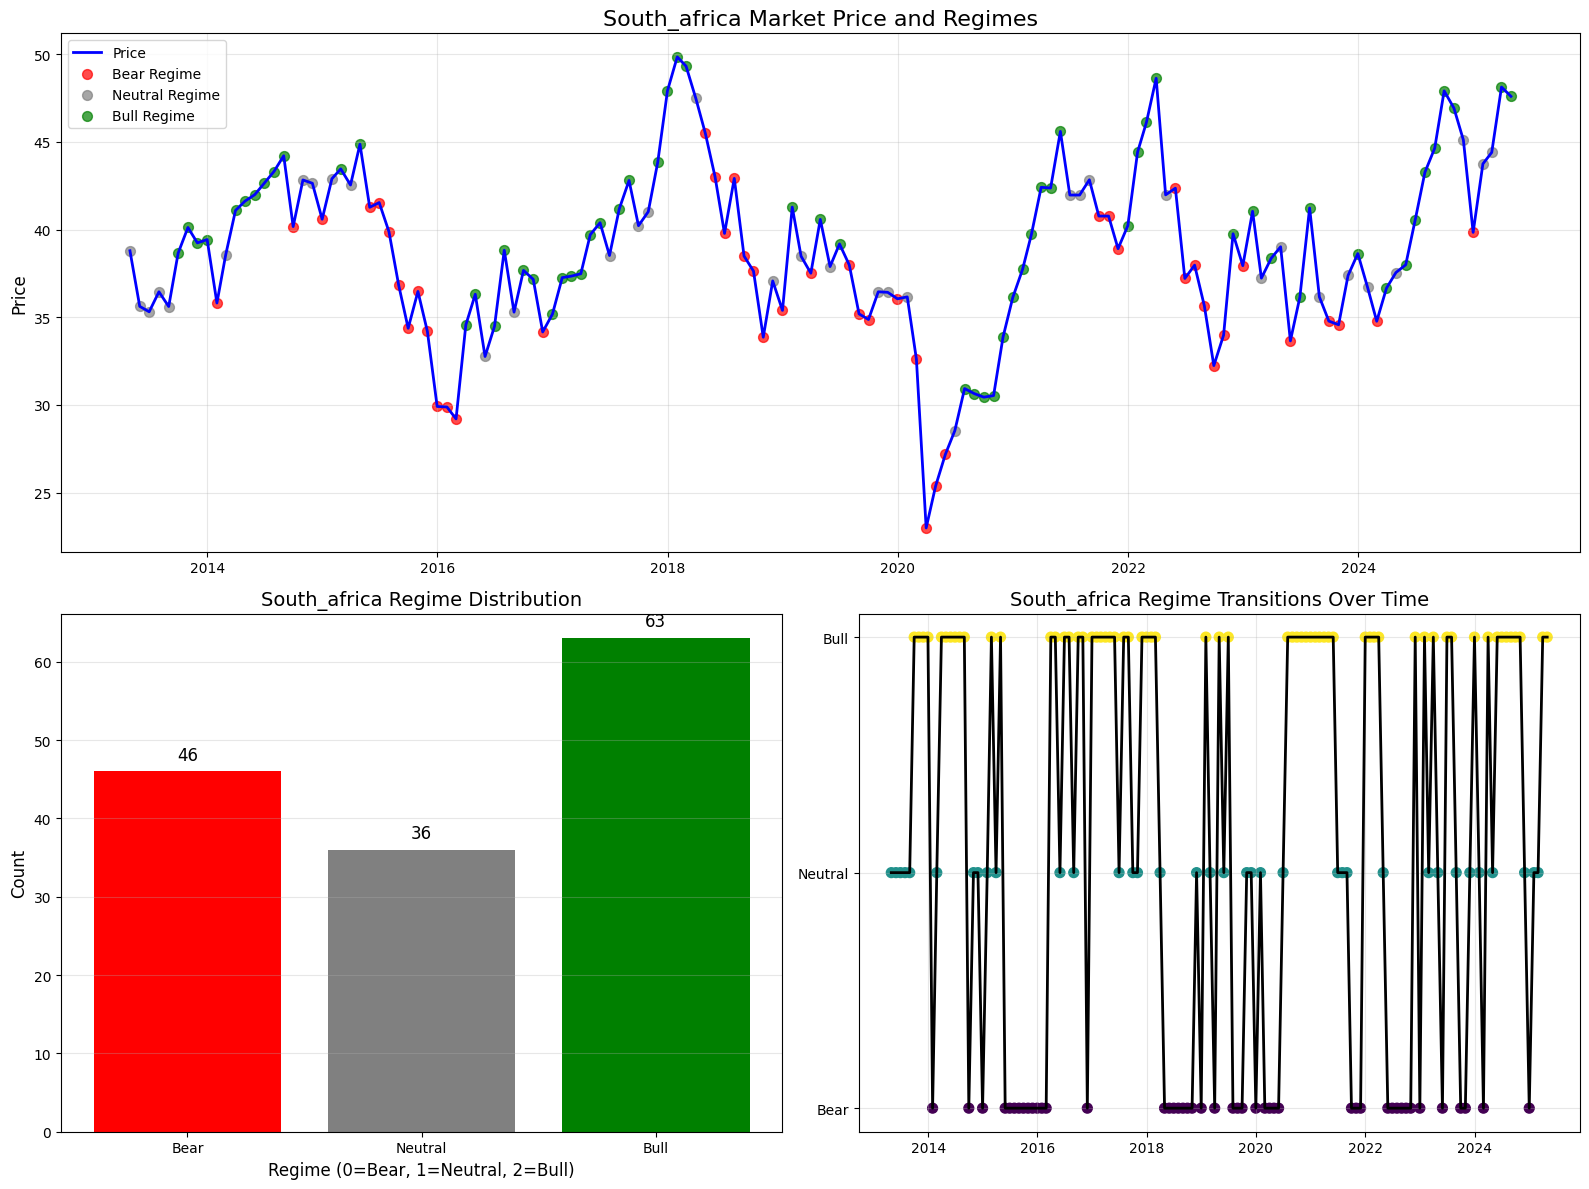

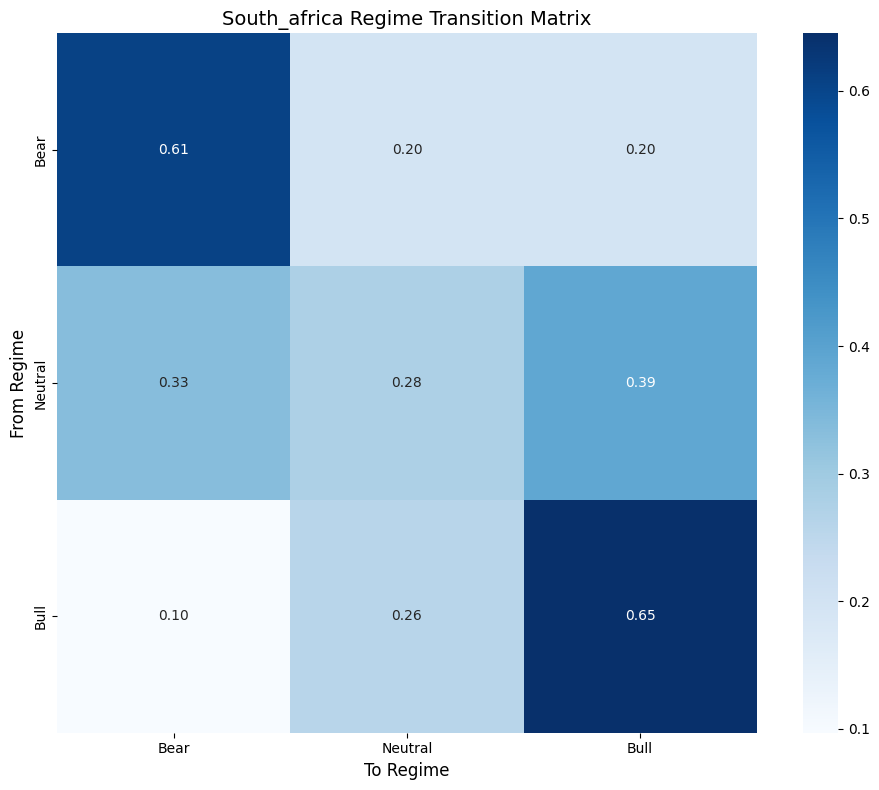

In [ ]:
def run_eda_pipeline():
    """Execute the full EDA pipeline for all countries"""
    # Countries to analyze
    countries = ['brazil', 'india', 'south_africa']

    # Store processed data
    processed_data = {}

    for country in countries:
        print(f"\n{'='*50}")
        print(f"PROCESSING {country.upper()}")
        print(f"{'='*50}")

        # 1. Load and process data
        data = load_and_process_data(country)

        if data is None:
            print(f"Failed to process data for {country}. Skipping to next country.")
            continue

        # 2. Engineer features
        featured_data = engineer_features(data)
        print(f"Engineered features. Shape: {featured_data.shape}")

        # 3. Perform EDA
        perform_eda(featured_data, country)

        # 4. Label market regimes
        labeled_data = label_market_regimes(featured_data)

        if labeled_data is not None:
            print("\nRegime distribution:")
            print(labeled_data['regime'].value_counts())

            # 5. Visualize market regimes
            visualize_regimes(labeled_data, country)

            # Store processed data
            processed_data[country] = labeled_data

    return processed_data

# Run the EDA pipeline
if __name__ == "__main__":
    processed_data = run_eda_pipeline()
